In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/kmeans-balanced-dataset/yelp_nyc_X_tf_idf_balanced.csv
/kaggle/input/kmeans-balanced-dataset/Наивный Байес_confusion_matrix.png
/kaggle/input/kmeans-balanced-dataset/Метод ближайших соседей_confusion_matrix.png
/kaggle/input/kmeans-balanced-dataset/Случайный лес_confusion_matrix.png
/kaggle/input/kmeans-balanced-dataset/Логистическая регрессия_confusion_matrix.png
/kaggle/input/kmeans-balanced-dataset/Мини-пакетный метод стохастического градиентного спуска_confusion_matrix.png
/kaggle/input/kmeans-balanced-dataset/yelp_nyc_y_labels_balanced.csv
/kaggle/input/kmeans-balanced-dataset/Машина опорных векторов_confusion_matrix.png
/kaggle/input/kmeans-balanced-dataset/yelp_nyc_kmeans_balancing.csv
/kaggle/input/kmeans-balanced-dataset/LogisticRegression с подбором параметров_confusion_matrix.png
/kaggle/input/kmeans-balanced-dataset/Voting-классификатор_confusion_matrix.png
/kaggle/input/kmeans-balanced-dataset/RandomForest_confusion_matrix.png
/kaggle/input/glove-embeddings/g

In [2]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/word

In [3]:

def set_seed(seed: int = 42):
    import random
    """
    Фиксирует seed для всех источников случайности.

    Args:
        seed (int): Значение seed.
    """
    # Python's random module
    random.seed(seed)
    
    # NumPy
    np.random.seed(seed)
    
    # PyTorch
    torch.manual_seed(seed)
    
    # Если используется CUDA (GPU)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # Для multi-GPU.

In [4]:
set_seed(42)

In [5]:
df = pd.read_csv('/kaggle/input/kmeans-balanced-dataset/yelp_nyc_kmeans_balancing.csv')
df

,Unnamed: 0.1,Unnamed: 0,user_id,prod_id,review,rating,label,prod_name,date,avg_prod_rating,avg_user_rating,review_len,cnt_reviews,neg,neu,pos,compound,cap_words,digit_words
0,39569,39569,31003,95,"First of all, the wait is super long so be pre...",3.0,1,Ippudo Westside,2014-11-20,4.03,3.50,401,2,0.023,0.625,0.352,0.9834,0,0
1,202817,202817,15455,542,Great pizza.,4.0,1,Lombardi’s Pizza,2012-07-06,3.94,3.74,12,19,0.000,0.196,0.804,0.6249,0,0
2,167376,167376,94480,465,5 starts for the food as its probably the best...,5.0,1,Grimaldi’s,2010-04-17,3.75,4.50,230,2,0.058,0.805,0.137,0.6071,1,1
3,349777,349777,52587,247,"The first time I went here, I went with 8 frie...",5.0,1,Ippudo NY,2012-08-01,4.07,4.20,1741,5,0.055,0.798,0.147,0.9832,7,3
4,84713,84713,56708,243,It's no secret that Roberta's is overpriced gi...,4.0,1,Roberta’s,2013-12-16,3.91,4.00,539,1,0.104,0.750,0.146,0.7569,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72150,358478,358478,161046,921,Bijan is the best bar I have been to in Brookl...,5.0,-1,Bijan’s,2011-12-01,4.17,5.00,244,1,0.055,0.797,0.148,0.6352,0,0
72151,358479,358479,161047,921,Great local lounge spot! After work and regula...,5.0,-1,Bijan’s,2011-11-15,4.17,5.00,169,1,0.000,0.546,0.454,0.9600,0,0
72152,358639,358639,161111,349,First and last time we try this place. Pizza ...,1.0,-1,Emily,2014-03-25,4.19,1.00,866,1,0.079,0.822,0.099,0.4848,6,0
72153,358640,358640,161112,349,"The staff was incredibly nice, the lemonade ta...",3.0,-1,Emily,2014-04-09,4.19,3.00,398,1,0.000,0.834,0.166,0.8460,1,0


In [6]:
reviews_texts = df[['review', 'label']]
reviews_texts.isna().sum()

review    0
label     0
dtype: int64

In [7]:
x_tfidf = pd.read_csv('/kaggle/input/kmeans-balanced-dataset/yelp_nyc_X_tf_idf_balanced.csv')

In [8]:
x_tfidf.drop('Unnamed: 0', axis = 1, inplace = True)

In [9]:
y_tfidf = pd.read_csv('/kaggle/input/kmeans-balanced-dataset/yelp_nyc_y_labels_balanced.csv')

In [10]:
y_tfidf.drop('Unnamed: 0', axis = 1, inplace = True)

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


In [12]:
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(x_tfidf, y_tfidf, test_size=0.2, random_state=42)

In [13]:
X_train_tfidf.shape, X_test_tfidf.shape, y_train_tfidf.shape, y_test_tfidf.shape

((57724, 1000), (14431, 1000), (57724, 1), (14431, 1))

In [14]:
lr =  LogisticRegression(random_state=42)

lr.fit(X_train_tfidf, y_train_tfidf)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(random_state=42)

In [15]:
y_pred = lr.predict(X_test_tfidf)

In [16]:
from sklearn.metrics import classification_report

print(classification_report(y_test_tfidf, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.85      0.80      7368
           1       0.83      0.72      0.77      7063

    accuracy                           0.79     14431
   macro avg       0.79      0.79      0.79     14431
weighted avg       0.79      0.79      0.79     14431



# Базовая предобработка текстов

In [17]:
! pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 7.1 MB/s eta 0:00:00


In [18]:
import re
import contractions

stop_words = set(stopwords.words('english'))
def preprocess_review(text):
    text = contractions.fix(text)
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\d'\s]", '', text)
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

text = "This is an example for wifes test 145 13 we're don't"
preprocess_review(text)

'example wifes test 145 13'

In [19]:
reviews_texts['review'] = reviews_texts['review'].apply(preprocess_review)

<ipython-input-19-b428cbb01f8b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_texts['review'] = reviews_texts['review'].apply(preprocess_review)


In [20]:
reviews_texts['review'].head(10)

0    first wait super long prepared food pretty goo...
1                                          great pizza
2    5 starts food probably best pizza nation chees...
3    first time went went 8 friends late lunch need...
4    secret roberta 's overpriced given inelasticit...
5    minca one favorite ramen bar manhattan wheneve...
6    came chocolate mousse red velvet cheesecake co...
7    friend went ramen joint near greenwich village...
8    place omg everyone great especially jimmy food...
9    ippudo list restaurants eat trip nyc came reco...
Name: review, dtype: object

In [21]:
for r in reviews_texts['review']:
    splitted_r = r.split()
    short_reviews_list = []
    if len(splitted_r)<300:
        short_review = ' '.join(splitted_r)
        short_reviews_list.append(short_review)

print(len(short_reviews_list))
print(len(short_reviews_list[0].split()))


1
27


# Torch классы и функции

In [22]:
import matplotlib.pyplot as plt

In [23]:
def load_embedding_from_file(path_to_embedding):
    embeddings = {}
    with open(path_to_embedding, 'r', encoding='utf-8') as f:
        for line in f:
            splitted_line = line.strip().split()
            word = splitted_line[0]
            vector = np.array(splitted_line[1:])
            # print(word, vector, vector.shape)
            embeddings[word] = vector
    return embeddings
    

In [24]:
from collections import Counter

def build_vocabulary_and_embeddings(reviews, embeddings:dict, embedding_dim:int):
    vocabulary = {
        'PAD' : 0,
        'UKN' : 1,
    }

    counter = Counter()
    not_in_embeddings = []
    for review in reviews:
        counter.update(review.strip().split())
    # print(counter.most_common())

    # Построение словаря. most_common - для аггрегации слов
    for word, _ in counter.most_common():
        if word in embeddings:
            vocabulary[word] = len(vocabulary)
        else:
            not_in_embeddings.append(word)
    print('Кол-во слов, которых нет в эмбеддинге:', len(not_in_embeddings))

    embedding_matrix = np.zeros((len(vocabulary), embedding_dim))    

    for word, index in vocabulary.items():
        if word in embeddings:
            embedding_matrix[index] = embeddings[word]
        elif word == 'UKN':
            embedding_matrix[index] = np.random.normal(scale=0.6, size=(embedding_dim,))

    return vocabulary, embedding_matrix
    
# vocabulary2, embedding_matrix2 = build_vocabulary_and_embeddings(['very good', 'very nice', 'super good'], 
                                                               # glove_dict, 
                                                               # 300)
# print(vocabulary2)
# print(embedding_matrix2[1])

In [25]:
class ReviewsDataset(Dataset):
    def __init__(self, reviews, labels, vocabulary, embedding_matrix, max_len):
        self.reviews = reviews
        self.labels = labels
        self.vocabulary = vocabulary
        self.embedding_matrix = embedding_matrix
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, index):
        review = self.reviews[index]
        label = self.labels[index]
        # работа с токенами в отзыве
        tokens = review.split()[:self.max_len] # берем определенное количество токенов
        inds = [self.vocabulary.get(tok, self.vocabulary['UKN']) for tok in tokens] # вычисляем их индексы
        # заполнение нулями
        padding_length = self.max_len - len(inds)
        inds += [self.vocabulary['PAD']] * padding_length
        return torch.tensor(inds), torch.tensor(label)

In [26]:
import numpy as np
import torch
class Early_stopping:
    def __init__(self, patience=3, delta=0.0, save_path='model_weights.pth'):
        self.patience = patience
        self.delta = delta
        self.save_path = save_path
        self.best_loss = np.inf
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            print(f"Best loss: {self.best_loss}")
            self.counter = 0
            torch.save(model.state_dict(), self.save_path) # сохраняем веса наилучшей модели
            model.load_state_dict(torch.load(self.save_path, weights_only=True))
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                print("Early stopping triggered! Best model weights saved.")

In [27]:
def unfreeze_embeddings(model):
    for param in model.embedding.parameters():
         param.requires_grad = True
    print('Embeddings unfreeze')

In [28]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,classification_report, confusion_matrix

def compute_metrics(labels, preds):
    # Преобразуем предсказания в вероятности (если нужно)
    # print(preds)
    # preds = [int(p) for p in preds]
    # preds_classes = np.round(probs).astype(int)

    if np.any(np.isnan(preds)):
        print("Warning: NaN values found in predictions!")
        preds = np.nan_to_num(preds)  # Заменяем NaN на 0
    preds_classes = np.round(preds).astype(int)
    
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, zero_division=0)
    recall = recall_score(labels, preds, zero_division=0)
    f1 = f1_score(labels, preds, zero_division=0)
    auc = roc_auc_score(labels, preds) 
    # if len(np.unique(labels)) > 1 else 0.5  # AUC требует обоих классов

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'F1': f1,
        'AUC': auc
    }

def show_metrics(y_true, y_pred, title):
    print(f'''
                {title}
==========================================
 auc: {roc_auc_score(y_true, y_pred)}             
==========================================
 report:                                
{classification_report(y_true, y_pred)}
==========================================

    ''')    

def show_confusion_matrix(y_true, y_pred, title_string):
    conf = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,8))
    plt.title(title_string)
    sns.heatmap(conf, fmt='d', annot=True)
    plt.savefig(title_string+'_confusion_matrix.png')
    plt.show()

In [29]:
def train_model(model, train_loader, valid_loader, criterion, optimizer, device, num_epochs, early_stopping=None):
    # сохраняем историю во время обучения
    history = {
        'train_loss':[],
        'train_accuracy' :[],
        'train_precision':[],
        'train_recall':[],
        'train_F1':[],
        'train_AUC': [],
        'val_loss':[],
        
        'val_accuracy' :[],
        'val_precision':[],
        'val_recall':[],
        'val_F1':[],
        'val_AUC':[]
    }   

    grad_logs = {}
    flag_freeze = False
    
    for epoch in tqdm(range(num_epochs), desc="Epochs", position=0): 
        print(f'\nEpoch {epoch + 1}/{num_epochs}')
        print('-' * 20)

        # Режим обучения
        model.train()
        train_losses = []
        train_preds = []
        train_labels = []
        print('-----Обучение-----')
        for inputs, labels in train_loader:
        # with torch.autograd.detect_anomaly():
            inputs, labels = inputs.to(device), labels.float().unsqueeze(1).to(device)
            optimizer.zero_grad() # обнуляем градиенты для текущего батча
            outputs = model(inputs) # вычисляем выход модели

            # if (epoch == 12) and not(flag_freeze) :
            #     unfreeze_embeddings(model)
            #     flag_freeze = True
            
            
            if torch.any(torch.isnan(outputs)):
                print("NAN значения среди outputs!")
                print(outputs[:4])
                return history, grad_logs
            
            loss = criterion(outputs, labels) # вычисляем loss для батча
            if torch.isnan(loss):
                print("NaN в лоссе!")
                print(f'''
                -----------------------
                -----------------------
                loss: {loss}
                -----------------------
                -----------------------
                inputs: {inputs}
                -----------------------
                -----------------------
                outputs: {outputs}
                -----------------------
                -----------------------
                
                ''')
                return history, grad_logs
            train_losses.append(loss.item()) 
            loss.backward()
                
            # вывод градиента, проверка на взрыв/затухание
            for name, param in model.named_parameters():
                if param.grad is not None:
                    if name not in grad_logs.keys():
                        grad_logs[name] = []    
                    grad_logs[name].append(param.grad.norm().item())
                    
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
            
            optimizer.step()

            preds = torch.sigmoid(outputs).round().detach().cpu().numpy()
            if np.any(np.isnan(preds[:4])):
                print("NAN значения среди preds!")
                print(preds)
                return history, grad_logs
            labels = labels.detach().cpu().numpy()
            train_preds.extend(preds.flatten())
            train_labels.extend(labels.flatten())
        # считаем показатели после эпохи
        train_loss = sum(train_losses) / len(train_losses) # среднее на эпохе
        train_metrics = compute_metrics(train_labels, train_preds) # метрики на эпохе
        # сохранем историю после эпохи
        for name, value in train_metrics.items():
            history[f"train_{name}"].append(value)
        history['train_loss'].append(train_loss)
        #======#
        
        # режим валидации
        model.eval()
        val_losses = []
        val_preds = []
        val_labels = []

        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.float().unsqueeze(1).to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_losses.append(loss.item())

                preds = torch.sigmoid(outputs).round().detach().cpu().numpy()
                labels = labels.detach().cpu().numpy()

                val_preds.extend(preds)
                val_labels.extend(labels)
            
            val_loss = sum(val_losses) / len(val_losses)
            val_metrics = compute_metrics(val_labels, val_preds)
            for metric_name, metric_value in val_metrics.items():
                history[f'val_{metric_name}'].append(metric_value)
            history['val_loss'].append(val_loss)
         # Вывод метрик
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_metrics["accuracy"]:.4f} | ',
              f'Train Precision: {train_metrics["precision"]:.4f} | Train Recall: {train_metrics["recall"]:.4f} | ',
              f'Train F1: {train_metrics["F1"]:.4f} | Train AUC: {train_metrics["AUC"]:.4f}')
        
        print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_metrics["accuracy"]:.4f} | ',
              f'Val Precision: {val_metrics["precision"]:.4f} | Val Recall: {val_metrics["recall"]:.4f} | ',
              f'Val F1: {val_metrics["F1"]:.4f} | Val AUC: {val_metrics["AUC"]:.4f}')

        if early_stopping is not None:
            early_stopping(val_loss, model)
            if early_stopping.early_stop:
                print(f'Stop after {epoch} epochs')
                return history, grad_logs
        
    return history, grad_logs

In [30]:
def plot_metrics(history, model_name):
    """
    Визуализирует метрики из словаря history.

    :param history: Словарь, содержащий метрики обучения и валидации.
    """
    # Проверяем, есть ли данные для визуализации
    if not history:
        print("Словарь history пуст.")
        return

    # Извлекаем метрики из history
    metrics = ['loss', 'accuracy', 'precision', 'recall', 'F1', 'AUC']
    train_metrics = [f'train_{metric}' for metric in metrics]
    val_metrics = [f'val_{metric}' for metric in metrics]

    # Создаём графики для каждой метрики
    plt.figure(figsize=(15, 10))
    plt.title(f"Процесс обучения {model_name}")
    for i, (metric, val_metric) in enumerate(zip(train_metrics, val_metrics)):
        plt.subplot(2, 3, i + 1)  # 2 строки, 3 столбца, i+1 — позиция графика
        if metric in history:
            plt.plot(history[metric], label=f'Обучение')
        if val_metric in history:
            plt.plot(history[val_metric], label=f'Валидация')

        plt.title(metric.capitalize()[6:])
        plt.xlabel('Эпохи')
        plt.ylabel("Значения метрики")
        plt.legend()
    plt.savefig(f'Процесс обучения {model_name}')
    plt.tight_layout()
    plt.show()

In [31]:
def eval_model(model, test_loader, criterion, device):
    model.eval()
    losses = []
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating(test)"):
            inputs, labels = inputs.to(device), labels.float().unsqueeze(1).to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())

            preds = torch.sigmoid(outputs).round().detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            all_preds.extend(preds.flatten())
            all_labels.extend(labels.flatten())

    metrics = compute_metrics(all_labels, all_preds)
    metrics['loss'] = sum(losses) / len(losses)
    return sum(losses) / len(losses), metrics, all_labels, all_preds
            

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_metrics_eval(history_dict, model_name):
    keys = list(history_dict.keys())
    values = list(map(lambda x: round(x, 4), list(history_dict.values())))
    
    print(keys)
    print(values)
    
    plt.figure(figsize=(12,8))
    ax = sns.barplot(x=keys, y=values)
    plt.xlabel('Метрики')
    plt.ylabel('Значения метрик')
    plt.title(f'Метрики {model_name} на тестовой выборке')
    for p, l in zip(ax.patches, values):
        ax.text(p.get_x() + p.get_width() / 2, p.get_height(), l, ha = 'center', va = 'bottom')   
    plt.legend()

    plt.savefig(f'Метрики {model_name} на тестовой выборке.png')
    plt.tight_layout()
    plt.show()

# Предобработка

In [33]:
reviews_texts.head(4)

,review,label
0,first wait super long prepared food pretty goo...,1
1,great pizza,1
2,5 starts food probably best pizza nation chees...,1
3,first time went went 8 friends late lunch need...,1


In [34]:
reviews_texts['label'] = reviews_texts['label'].replace(-1, 0)
reviews_texts.tail(4)


<ipython-input-34-affa42ad5df4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_texts['label'] = reviews_texts['label'].replace(-1, 0)


,review,label
72151,great local lounge spot work regular nights gr...,0
72152,first last time try place pizza crust hard roc...,0
72153,staff incredibly nice lemonade tasty salads cr...,0
72154,emily 's inspired start yelp account love plac...,0


In [35]:
glove_path = '/kaggle/input/glove-embeddings/glove.6B.300d.txt'
glove_dict = load_embedding_from_file(glove_path)


In [36]:
vocabulary, embedding_matrix = build_vocabulary_and_embeddings(reviews_texts['review'], embeddings=glove_dict, embedding_dim=300)


Кол-во слов, которых нет в эмбеддинге: 46726


In [37]:
print(len(vocabulary))
print(embedding_matrix.shape)
# ukn = vocabulary['UKN']
# print(ukn)
# print(embedding_matrix[ukn])

print(vocabulary.get('qqqqq', vocabulary['UKN']))


40395
(40395, 300)
1


In [38]:
pad = vocabulary['PAD']
print(pad)
print(embedding_matrix[pad])
type(embedding_matrix)

0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


numpy.ndarray

In [39]:
vocabulary_keys = list(vocabulary.keys())
not_in_glove = []
for key in vocabulary_keys:
    if key not in glove_dict.keys():
        not_in_glove.append(key)
print(not_in_glove)
    

['PAD', 'UKN']


In [40]:
reviews_texts['review']

0        first wait super long prepared food pretty goo...
1                                              great pizza
2        5 starts food probably best pizza nation chees...
3        first time went went 8 friends late lunch need...
4        secret roberta 's overpriced given inelasticit...
                               ...                        
72150    bijan best bar brooklyn far joke something dow...
72151    great local lounge spot work regular nights gr...
72152    first last time try place pizza crust hard roc...
72153    staff incredibly nice lemonade tasty salads cr...
72154    emily 's inspired start yelp account love plac...
Name: review, Length: 72155, dtype: object

In [41]:
full_dataset = ReviewsDataset(reviews = reviews_texts['review'], 
                             labels = reviews_texts['label'],
                             vocabulary = vocabulary,
                             embedding_matrix = embedding_matrix,
                             max_len = 256
                            )

In [42]:
from torch.utils.data import random_split
generator = torch.Generator().manual_seed(42)
train_dataset, valid_dataset, test_dataset = random_split(full_dataset, [0.75, 0.05, 0.2], generator=generator)

print(f"""
Размер тренировочного набора: {len(train_dataset)}, 
Размер валидационного набора: {len(valid_dataset)}, 
Размер тестового набора: {len(test_dataset)}, 
"""
)


Размер тренировочного набора: 54117, 
Размер валидационного набора: 3607, 
Размер тестового набора: 14431, 



In [43]:
# cnt_fake, cnt_true = 0, 0
# for _, labels in train_loader:
#         cnt_fake += (labels==0).sum()
#         cnt_true += (labels==1).sum()
    
# print('фейковые: ', cnt_fake, 'настоящие: ', cnt_true)

In [44]:
# cnt_fake, cnt_true = 0, 0
# for _, labels in valid_loader:
#         cnt_fake += (labels==0).sum()
#         cnt_true += (labels==1).sum()
    
# print('фейковые: ', cnt_fake, 'настоящие: ', cnt_true)

In [45]:
# cnt_fake, cnt_true = 0, 0
# for _, labels in test_loader:
#         cnt_fake += (labels==0).sum()
#         cnt_true += (labels==1).sum()
    
# print('фейковые: ', cnt_fake, 'настоящие: ', cnt_true)

In [46]:
train_loader = DataLoader(train_dataset, batch_size = 256, shuffle = True)
valid_loader = DataLoader(valid_dataset, batch_size = 256, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = 32)


# Модели

In [47]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F

In [48]:
def init_weights(m):
    if isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'weight_ih' in name:  # Веса входного слоя
                init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:  # Веса рекуррентного слоя
                init.orthogonal_(param.data)  
            elif 'bias' in name:  # Смещения (bias)
                param.data.fill_(0)

    elif isinstance(m, nn.Linear):  # Полносвязный слой
        init.xavier_uniform_(m.weight.data)
        if m.bias is not None:
            m.bias.data.fill_(0)

# Simple LSTM

In [49]:
#Гиперпараметры
embedding_dim = 300
hidden_dim = 256
output_dim = 1
lr = 0.005
num_epochs = 100
dropout_rate = 0.25
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)



cuda


In [50]:
simple_lstm_model = nn.Sequential(
    nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32)),
    nn.Dropout(dropout_rate),
    nn.LSTM(input_size=embedding_matrix.shape[1], hidden_size=hidden_dim, batch_first=True),
    nn.Linear(hidden_dim, output_dim)
)
print(simple_lstm_model)

Sequential(
  (0): Embedding(40395, 300)
  (1): Dropout(p=0.25, inplace=False)
  (2): LSTM(300, 256, batch_first=True)
  (3): Linear(in_features=256, out_features=1, bias=True)
)


## Обучение Simple LSTM

In [51]:
class LSTM_model(nn.Module):
    def __init__(self, vocab_size, embedding_matrix, embedding_dim, hidden_dim, output_dim, dropout_rate):
        super(LSTM_model, self).__init__()
        embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)

        self.embedding = nn.Embedding.from_pretrained(embedding_matrix)
        self.embedding.weight.requires_grad = True # заморозка весов для эмбеддинга
        self.embedding_dropout = nn.Dropout(dropout_rate)
        self.lstm = nn.LSTM(
                            input_size=embedding_matrix.shape[1],
                            num_layers=1,
                            hidden_size=hidden_dim,
                            batch_first=True,
                           )
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
        
    def forward(self, x):
        embedded = self.embedding(x)
        embedded = self.embedding_dropout(embedded)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = lstm_out[:, -1, :]  # Берем последний таймстеп
        output = self.fc2(lstm_out)
        return output
        

In [52]:
simple_lstm_model = LSTM_model(vocab_size=len(vocabulary),
                              embedding_matrix=embedding_matrix, 
                              embedding_dim=embedding_matrix.shape[1],
                              hidden_dim=hidden_dim, 
                              output_dim=output_dim,
                              dropout_rate=dropout_rate)

In [53]:
criterion = nn.BCEWithLogitsLoss() 
optimizer = optim.AdamW(simple_lstm_model.parameters(), lr=lr, weight_decay=0.0001)
early_stopping = Early_stopping(patience=6, delta=0.001, save_path='simple_lstm_model.pth')
simple_lstm_model.to(device)

LSTM_model(
  (embedding): Embedding(40395, 300)
  (embedding_dropout): Dropout(p=0.25, inplace=False)
  (lstm): LSTM(300, 256, batch_first=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
)

In [54]:
history, _ = train_model(model=simple_lstm_model, 
                        train_loader=train_loader,
                        valid_loader=valid_loader, 
                        criterion=criterion, 
                        optimizer=optimizer, 
                        device=device, 
                        num_epochs=num_epochs, 
                        early_stopping=early_stopping
                        )

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 1/100
--------------------
-----Обучение-----


Epochs:   1%|          | 1/100 [00:22<36:47, 22.30s/it]

Train Loss: 0.6939 | Train Acc: 0.5120 |  Train Precision: 0.5015 | Train Recall: 0.2815 |  Train F1: 0.3606 | Train AUC: 0.5070
Val Loss: 0.6236 | Val Acc: 0.7042 |  Val Precision: 0.6764 | Val Recall: 0.7118 |  Val F1: 0.6937 | Val AUC: 0.7046
Best loss: 0.6235784490903219

Epoch 2/100
--------------------
-----Обучение-----


Epochs:   2%|▏         | 2/100 [00:44<35:52, 21.96s/it]

Train Loss: 0.4980 | Train Acc: 0.7763 |  Train Precision: 0.8158 | Train Recall: 0.7006 |  Train F1: 0.7538 | Train AUC: 0.7746
Val Loss: 0.4851 | Val Acc: 0.7849 |  Val Precision: 0.7891 | Val Recall: 0.7407 |  Val F1: 0.7641 | Val AUC: 0.7824
Best loss: 0.4850624759991964

Epoch 3/100
--------------------
-----Обучение-----
Train Loss: 0.4596 | Train Acc: 0.7968 |  Train Precision: 0.8222 | Train Recall: 0.7455 |  Train F1: 0.7820 | Train AUC: 0.7957
Val Loss: 0.4814 | Val Acc: 0.7849 |  Val Precision: 0.7862 | Val Recall: 0.7454 |  Val F1: 0.7653 | Val AUC: 0.7827
Best loss: 0.48142144083976746


Epochs:   3%|▎         | 3/100 [01:06<35:45, 22.11s/it]


Epoch 4/100
--------------------
-----Обучение-----


Epochs:   4%|▍         | 4/100 [01:28<35:31, 22.21s/it]

Train Loss: 0.4110 | Train Acc: 0.8256 |  Train Precision: 0.8440 | Train Recall: 0.7892 |  Train F1: 0.8157 | Train AUC: 0.8248
Val Loss: 0.5036 | Val Acc: 0.7691 |  Val Precision: 0.7766 | Val Recall: 0.7148 |  Val F1: 0.7444 | Val AUC: 0.7660

Epoch 5/100
--------------------
-----Обучение-----


Epochs:   5%|▌         | 5/100 [01:51<35:43, 22.56s/it]

Train Loss: 0.3550 | Train Acc: 0.8547 |  Train Precision: 0.8691 | Train Recall: 0.8273 |  Train F1: 0.8477 | Train AUC: 0.8541
Val Loss: 0.5329 | Val Acc: 0.7549 |  Val Precision: 0.7314 | Val Recall: 0.7572 |  Val F1: 0.7441 | Val AUC: 0.7550

Epoch 6/100
--------------------
-----Обучение-----


Epochs:   6%|▌         | 6/100 [02:15<36:06, 23.04s/it]

Train Loss: 0.3049 | Train Acc: 0.8779 |  Train Precision: 0.8860 | Train Recall: 0.8609 |  Train F1: 0.8733 | Train AUC: 0.8775
Val Loss: 0.5891 | Val Acc: 0.7577 |  Val Precision: 0.7535 | Val Recall: 0.7207 |  Val F1: 0.7367 | Val AUC: 0.7556

Epoch 7/100
--------------------
-----Обучение-----


Epochs:   7%|▋         | 7/100 [02:40<36:43, 23.70s/it]

Train Loss: 0.2587 | Train Acc: 0.8971 |  Train Precision: 0.9074 | Train Recall: 0.8792 |  Train F1: 0.8931 | Train AUC: 0.8967
Val Loss: 0.6981 | Val Acc: 0.7455 |  Val Precision: 0.7371 | Val Recall: 0.7136 |  Val F1: 0.7251 | Val AUC: 0.7437

Epoch 8/100
--------------------
-----Обучение-----


Epochs:   8%|▊         | 8/100 [03:06<37:08, 24.22s/it]

Train Loss: 0.2239 | Train Acc: 0.9118 |  Train Precision: 0.9199 | Train Recall: 0.8977 |  Train F1: 0.9087 | Train AUC: 0.9115
Val Loss: 0.7825 | Val Acc: 0.7380 |  Val Precision: 0.7199 | Val Recall: 0.7254 |  Val F1: 0.7226 | Val AUC: 0.7373

Epoch 9/100
--------------------
-----Обучение-----


Epochs:   8%|▊         | 8/100 [03:30<40:21, 26.32s/it]

Train Loss: 0.1960 | Train Acc: 0.9241 |  Train Precision: 0.9335 | Train Recall: 0.9095 |  Train F1: 0.9214 | Train AUC: 0.9238
Val Loss: 0.8708 | Val Acc: 0.7311 |  Val Precision: 0.7069 | Val Recall: 0.7319 |  Val F1: 0.7192 | Val AUC: 0.7311
Early stopping triggered! Best model weights saved.
Stop after 8 epochs


<ipython-input-30-3aeef0aace76>:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 3, i + 1)  # 2 строки, 3 столбца, i+1 — позиция графика


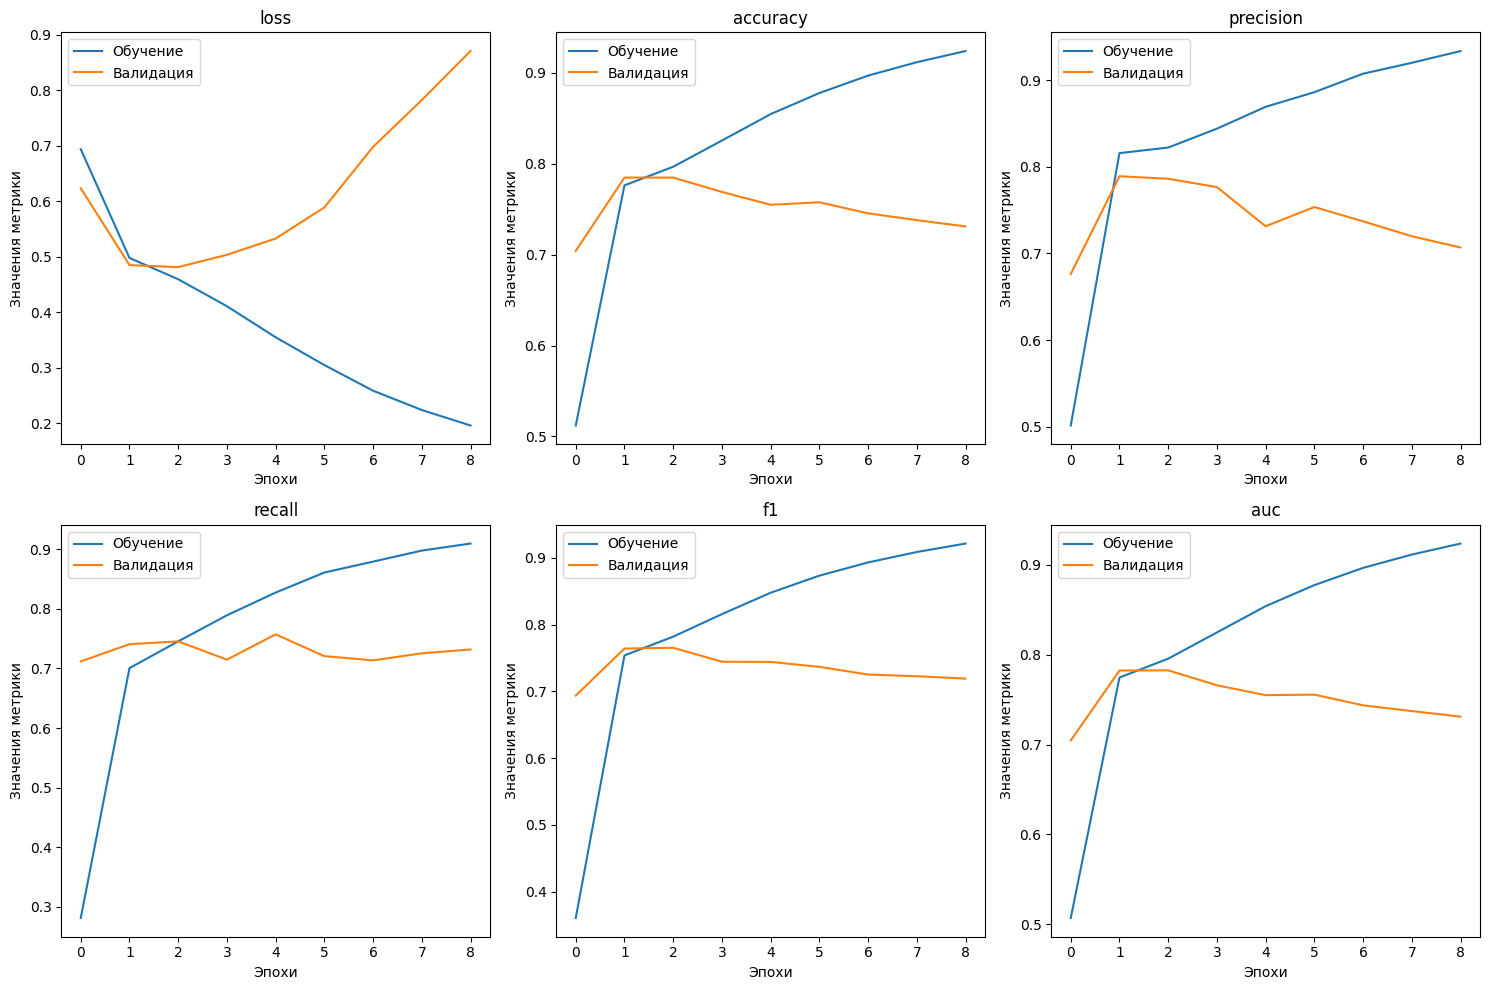

In [55]:
plot_metrics(history, model_name = 'LSTM')

In [56]:
simple_lstm_model.load_state_dict(torch.load('simple_lstm_model.pth', weights_only=True))

<All keys matched successfully>

## Оценка Simple LSTM

In [57]:
_, metrics, labels, preds = eval_model(simple_lstm_model, test_loader, criterion, device)

Evaluating(test): 100%|██████████| 451/451 [00:03<00:00, 120.07it/s]


In [58]:
show_metrics(labels, preds, 'LSTM')


                LSTM
 auc: 0.790742855175901             
 report:                                
              precision    recall  f1-score   support

         0.0       0.77      0.83      0.80      7273
         1.0       0.81      0.75      0.78      7158

    accuracy                           0.79     14431
   macro avg       0.79      0.79      0.79     14431
weighted avg       0.79      0.79      0.79     14431


    


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


['accuracy', 'precision', 'recall', 'F1', 'AUC', 'loss']
[0.7911, 0.8148, 0.7491, 0.7806, 0.7907, 0.4675]


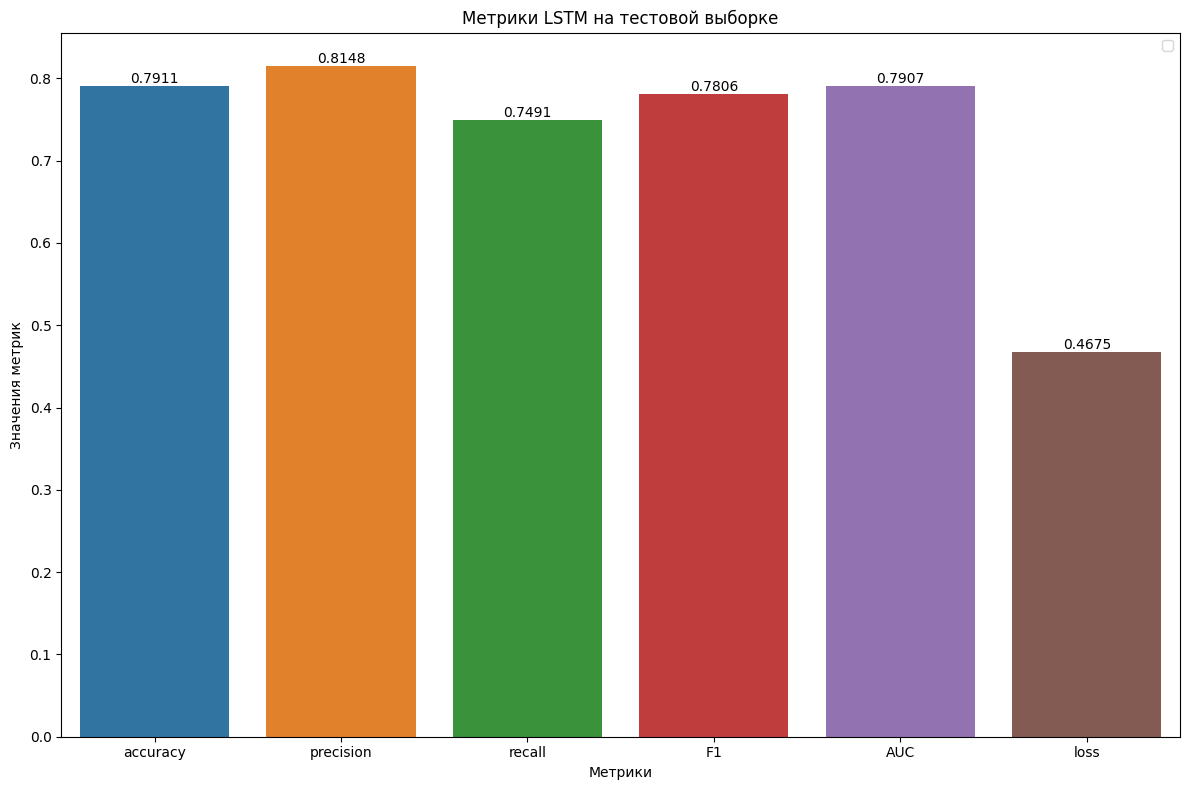

In [59]:
plot_metrics_eval(metrics, 'LSTM')

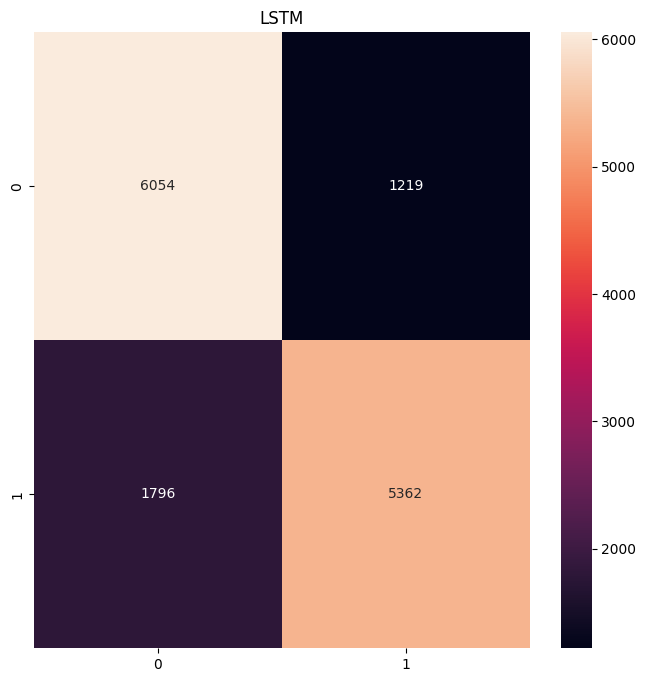

In [60]:
show_confusion_matrix(labels, preds, 'LSTM')

# Simple GRU

In [61]:
class GRU_model(nn.Module):
    def __init__(self, vocab_size, embedding_matrix, embedding_dim, hidden_dim, output_dim, dropout_rate):
        super(GRU_model, self).__init__()
        embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)

        self.embedding = nn.Embedding.from_pretrained(embedding_matrix)
        self.embedding.weight.requires_grad = True # заморозка весов для эмбеддинга
        self.embedding_dropout = nn.Dropout(dropout_rate)
        self.gru = nn.GRU(
                            input_size=embedding_matrix.shape[1],
                            num_layers=1,
                            hidden_size=hidden_dim,
                            batch_first=True,
                           ).to(device)
        # self.fc1 = nn.Linear(hidden_dim, 128).to(device)
        # self.relu = nn.ReLU().to(device)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
        
    def forward(self, x):
        embedded = self.embedding(x)
        embedded = self.embedding_dropout(embedded)
        gru_out, _ = self.gru(embedded)
        gru_out = gru_out[:, -1, :]  # Берем последний таймстеп
        # fc1_out = self.fc1(lstm_out)
        # fc1_out = self.relu(fc1_out)
        output = self.fc2(gru_out)
        return output
        

## Обучение Simple GRU

In [62]:
#Гиперпараметры
embedding_dim = 300
hidden_dim = 256
output_dim = 1
lr = 0.001
num_epochs = 100
dropout_rate = 0.25
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)



cuda


In [63]:
embedding_dim

300

In [64]:

simple_gru_model = GRU_model(vocab_size=len(vocabulary),
                              embedding_matrix=embedding_matrix, 
                              embedding_dim=embedding_matrix.shape[1],
                              hidden_dim=hidden_dim, 
                              output_dim=output_dim,
                              dropout_rate=dropout_rate)

In [65]:
print(simple_gru_model)


GRU_model(
  (embedding): Embedding(40395, 300)
  (embedding_dropout): Dropout(p=0.25, inplace=False)
  (gru): GRU(300, 256, batch_first=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
)


In [66]:
simple_gru_model.to(device)
criterion = nn.BCEWithLogitsLoss() 
optimizer = optim.AdamW(simple_gru_model.parameters(), lr=lr, weight_decay=0.0001)
early_stopping = Early_stopping(patience=5, delta=0.0001, save_path = "simple_GRU.pth")


In [67]:
history, grad_logs = train_model(simple_gru_model, train_loader, valid_loader, criterion, optimizer, device, num_epochs, early_stopping)

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 1/100
--------------------
-----Обучение-----


Epochs:   1%|          | 1/100 [00:20<33:41, 20.41s/it]

Train Loss: 0.6957 | Train Acc: 0.5133 |  Train Precision: 0.5067 | Train Recall: 0.1652 |  Train F1: 0.2492 | Train AUC: 0.5057
Val Loss: 0.6911 | Val Acc: 0.5326 |  Val Precision: 0.6897 | Val Recall: 0.0118 |  Val F1: 0.0232 | Val AUC: 0.5035
Best loss: 0.691121252377828

Epoch 2/100
--------------------
-----Обучение-----


Epochs:   2%|▏         | 2/100 [00:41<33:33, 20.54s/it]

Train Loss: 0.6356 | Train Acc: 0.5957 |  Train Precision: 0.7894 | Train Recall: 0.2359 |  Train F1: 0.3633 | Train AUC: 0.5879
Val Loss: 0.4792 | Val Acc: 0.7810 |  Val Precision: 0.8279 | Val Recall: 0.6747 |  Val F1: 0.7435 | Val AUC: 0.7751
Best loss: 0.4792002002398173

Epoch 3/100
--------------------
-----Обучение-----


Epochs:   3%|▎         | 3/100 [01:01<33:19, 20.61s/it]

Train Loss: 0.4657 | Train Acc: 0.7912 |  Train Precision: 0.8228 | Train Recall: 0.7300 |  Train F1: 0.7736 | Train AUC: 0.7898
Val Loss: 0.4569 | Val Acc: 0.7957 |  Val Precision: 0.8204 | Val Recall: 0.7242 |  Val F1: 0.7693 | Val AUC: 0.7917
Best loss: 0.45685441692670187

Epoch 4/100
--------------------
-----Обучение-----


Epochs:   4%|▍         | 4/100 [01:22<32:52, 20.54s/it]

Train Loss: 0.4237 | Train Acc: 0.8155 |  Train Precision: 0.8338 | Train Recall: 0.7777 |  Train F1: 0.8047 | Train AUC: 0.8147
Val Loss: 0.4668 | Val Acc: 0.7921 |  Val Precision: 0.8101 | Val Recall: 0.7289 |  Val F1: 0.7674 | Val AUC: 0.7886

Epoch 5/100
--------------------
-----Обучение-----


Epochs:   5%|▌         | 5/100 [01:42<32:31, 20.54s/it]

Train Loss: 0.3681 | Train Acc: 0.8462 |  Train Precision: 0.8570 | Train Recall: 0.8227 |  Train F1: 0.8395 | Train AUC: 0.8457
Val Loss: 0.5022 | Val Acc: 0.7813 |  Val Precision: 0.7940 | Val Recall: 0.7225 |  Val F1: 0.7566 | Val AUC: 0.7780

Epoch 6/100
--------------------
-----Обучение-----


Epochs:   6%|▌         | 6/100 [02:03<32:06, 20.50s/it]

Train Loss: 0.3105 | Train Acc: 0.8736 |  Train Precision: 0.8860 | Train Recall: 0.8509 |  Train F1: 0.8681 | Train AUC: 0.8731
Val Loss: 0.5617 | Val Acc: 0.7677 |  Val Precision: 0.7573 | Val Recall: 0.7448 |  Val F1: 0.7510 | Val AUC: 0.7664

Epoch 7/100
--------------------
-----Обучение-----


Epochs:   7%|▋         | 7/100 [02:23<31:41, 20.45s/it]

Train Loss: 0.2589 | Train Acc: 0.8972 |  Train Precision: 0.9096 | Train Recall: 0.8769 |  Train F1: 0.8930 | Train AUC: 0.8968
Val Loss: 0.6435 | Val Acc: 0.7596 |  Val Precision: 0.7418 | Val Recall: 0.7501 |  Val F1: 0.7460 | Val AUC: 0.7591

Epoch 8/100
--------------------
-----Обучение-----


Epochs:   7%|▋         | 7/100 [02:43<36:18, 23.43s/it]

Train Loss: 0.2168 | Train Acc: 0.9150 |  Train Precision: 0.9260 | Train Recall: 0.8979 |  Train F1: 0.9117 | Train AUC: 0.9146
Val Loss: 0.7503 | Val Acc: 0.7494 |  Val Precision: 0.7110 | Val Recall: 0.7873 |  Val F1: 0.7472 | Val AUC: 0.7515
Early stopping triggered! Best model weights saved.
Stop after 7 epochs


In [68]:
# for key in grad_logs.keys():
#     print(key, grad_logs[key][-150:])

In [69]:
# for key in grad_logs.keys():
#     print(key, max(grad_logs[key]))
#     print(key, min(grad_logs[key]))
#     print()
    

<ipython-input-30-3aeef0aace76>:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 3, i + 1)  # 2 строки, 3 столбца, i+1 — позиция графика


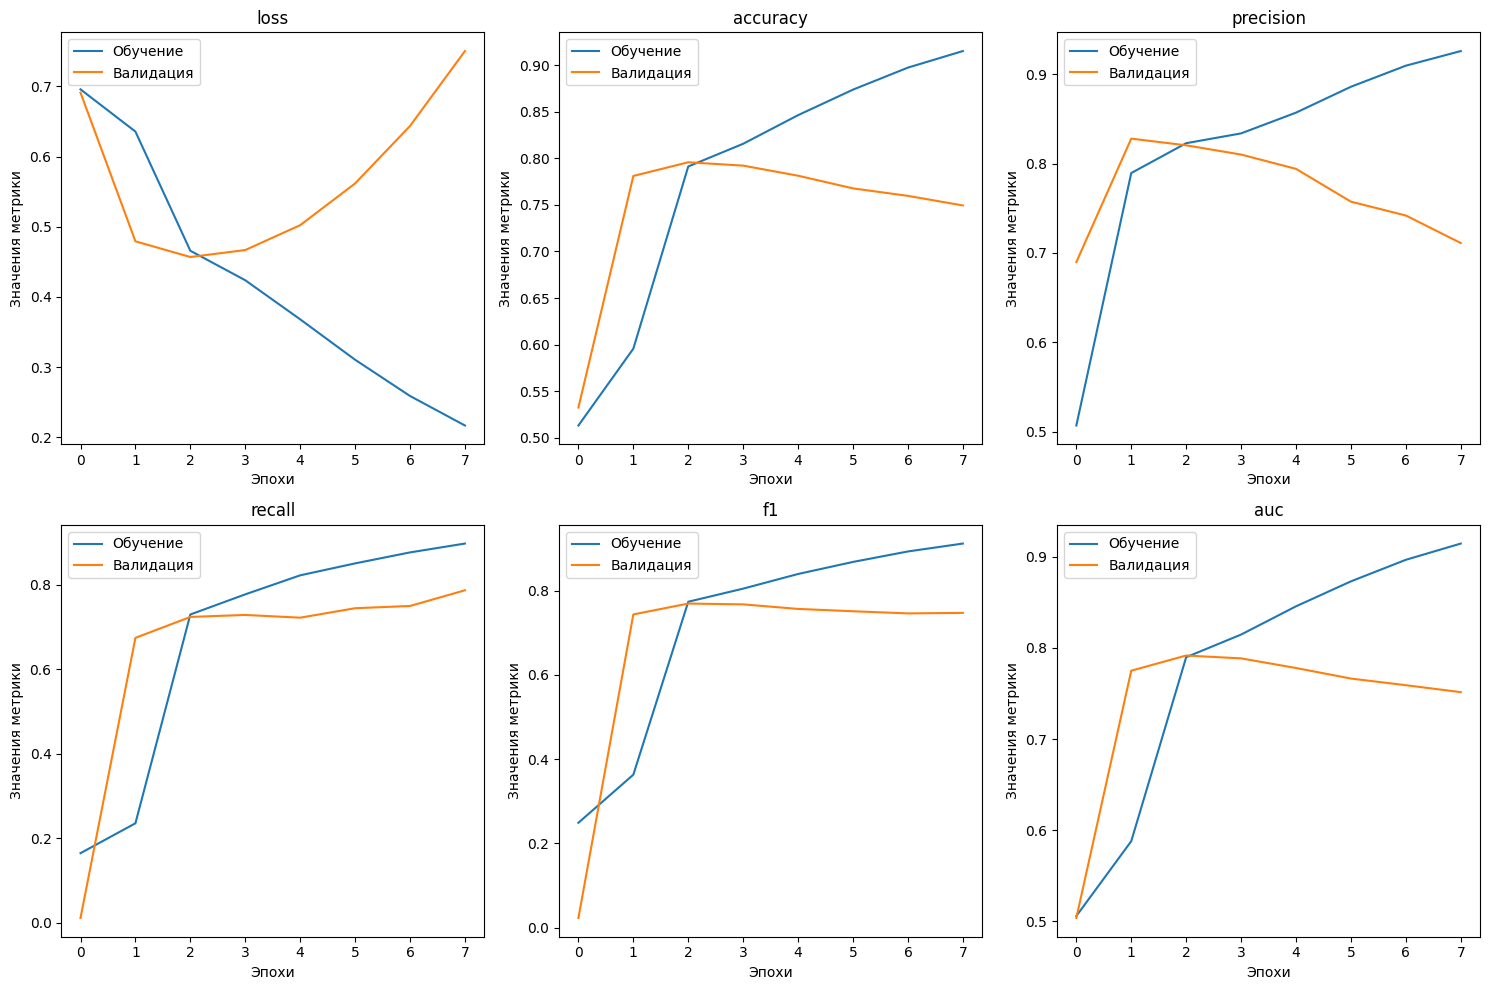

In [70]:
plot_metrics(history, 'GRU')

In [71]:
simple_gru_model.load_state_dict(torch.load('simple_GRU.pth', weights_only=True))

<All keys matched successfully>

## Оценка Simple GRU

In [72]:
loss_eval, metrics_eval, labels_eval, preds_eval = eval_model(simple_gru_model, test_loader, criterion, device)

Evaluating(test): 100%|██████████| 451/451 [00:03<00:00, 129.40it/s]


In [73]:
print(loss_eval),print(metrics_eval)

0.45397814146827437
{'accuracy': 0.7941237613470999, 'precision': 0.8364133054796722, 'recall': 0.7271584241408214, 'F1': 0.7779687616770047, 'AUC': 0.7935943365032444, 'loss': 0.45397814146827437}


(None, None)

In [74]:
labels_eval = np.array(labels_eval, dtype=np.int32)
preds_eval = np.array(preds_eval, dtype=np.int32)

show_metrics(labels_eval, preds_eval, f'Репорт GRU')


                Репорт GRU
 auc: 0.7935943365032444             
 report:                                
              precision    recall  f1-score   support

           0       0.76      0.86      0.81      7273
           1       0.84      0.73      0.78      7158

    accuracy                           0.79     14431
   macro avg       0.80      0.79      0.79     14431
weighted avg       0.80      0.79      0.79     14431


    


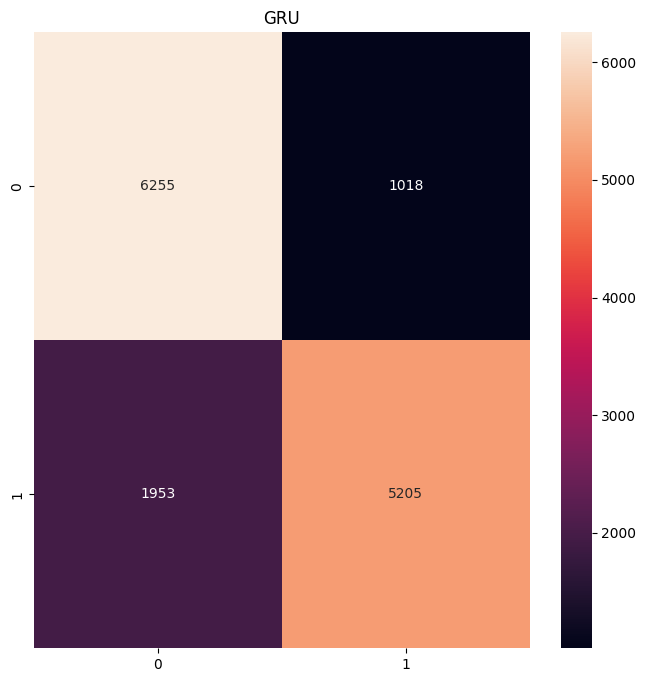

In [75]:
show_confusion_matrix(labels_eval, preds_eval, 'GRU')

In [76]:
# metrics_eval

['accuracy', 'precision', 'recall', 'F1', 'AUC', 'loss']
[0.7941, 0.8364, 0.7272, 0.778, 0.7936, 0.454]


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


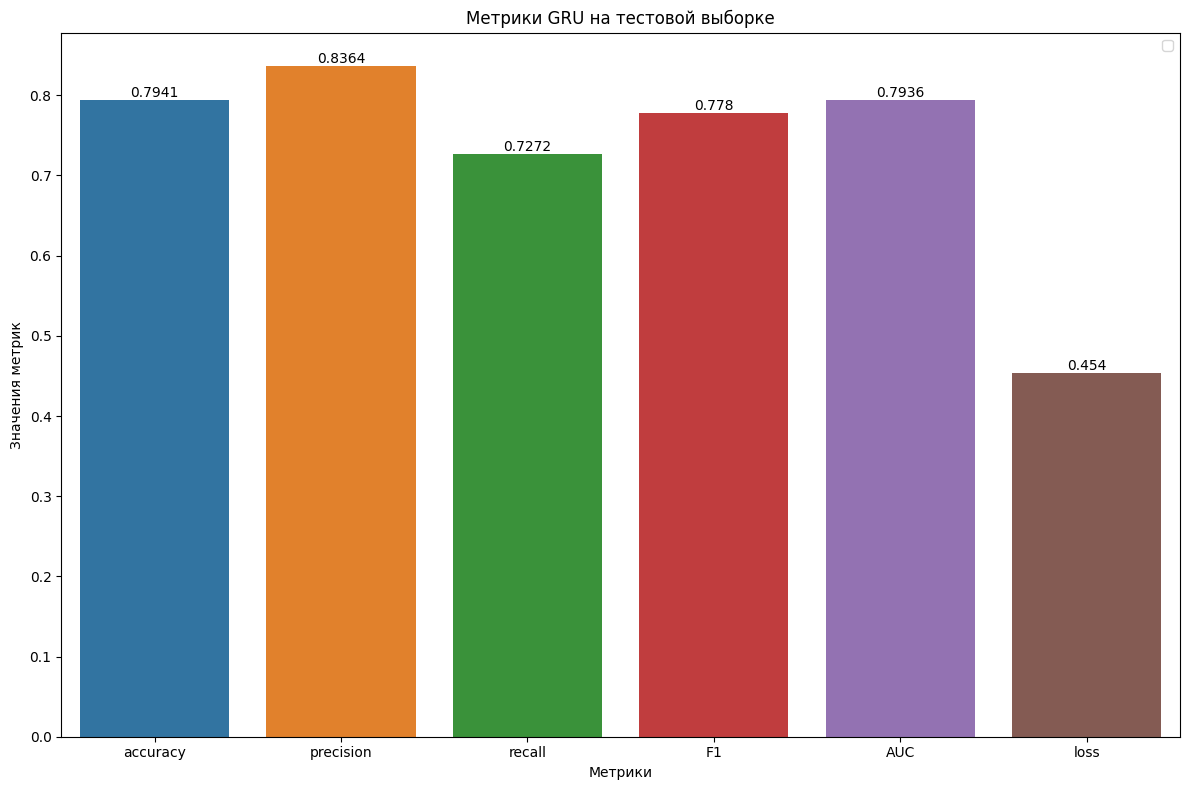

In [77]:
plot_metrics_eval(metrics_eval,'GRU')

# Bidirectional LSTM

In [78]:
class Bid_Lstm_model(nn.Module):
    def __init__(self, vocab_size, embedding_matrix, embedding_dim, hidden_dim, output_dim, dropout_rate, num_layers):
        super(Bid_Lstm_model, self).__init__()
        embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)

        self.embedding = nn.Embedding.from_pretrained(embedding_matrix)
        # self.embedding.weight.requires_grad = False # заморозка весов для эмбеддинга
        self.embedding_dropout = nn.Dropout(dropout_rate)
        self.lstm = nn.LSTM(
                            input_size=embedding_matrix.shape[1],
                            hidden_size=hidden_dim,
                            batch_first=True,
                            bidirectional=True,
                            num_layers = num_layers,
                            dropout= dropout_rate if num_layers > 1 else 0,
                           )
        self.fc1 = nn.Linear(2*hidden_dim, 128)
        self.batch_norm_1 = nn.BatchNorm1d(128)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)

        self.fc2 = nn.Linear(128, 64)
        self.batch_norm_2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.fc3 = nn.Linear(64, output_dim)
        
        
    def forward(self, x):
        embedded = self.embedding(x)
        embedded = self.embedding_dropout(embedded)
        lstm_out,_ = self.lstm(embedded)
        # lstm_out = lstm_out[:, -1, :]  # Берем последний таймстеп
        lstm_out = torch.max(lstm_out, dim=1)[0]
        fc1_out = self.fc1(lstm_out)
        fc1_out = self.batch_norm_1(fc1_out)
        fc1_out = self.relu(fc1_out)
        fc1_out = self.dropout1(fc1_out)
        fc2_out = self.fc2(fc1_out)
        fc2_out = self.batch_norm_2(fc2_out)
        fc2_out = self.relu(fc2_out)
        fc2_out = self.dropout2(fc2_out)
        
        output = self.fc3(fc2_out)
        return output
        

In [79]:
# print(simple_lstm_model)

## Обучение

In [80]:
#Гиперпараметры
embedding_dim = 300
hidden_dim = 256
output_dim = 1
lr = 0.005
num_epochs = 100
num_layers = 1
dropout_rate = 0.5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


In [81]:

bid_simple_lstm_model = Bid_Lstm_model(vocab_size=len(vocabulary),
                              embedding_matrix=embedding_matrix, 
                              embedding_dim=embedding_matrix.shape[1],
                              hidden_dim=hidden_dim, 
                              output_dim=output_dim,
                              dropout_rate=dropout_rate,
                              num_layers=num_layers)

In [82]:
init_weights(bid_simple_lstm_model)

In [83]:
print(bid_simple_lstm_model)

Bid_Lstm_model(
  (embedding): Embedding(40395, 300)
  (embedding_dropout): Dropout(p=0.5, inplace=False)
  (lstm): LSTM(300, 256, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (batch_norm_1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (batch_norm_2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)


In [84]:
criterion = nn.BCEWithLogitsLoss() 
optimizer = optim.AdamW(bid_simple_lstm_model.parameters(), lr=lr, weight_decay=0.0001)
early_stopping = Early_stopping(patience=4, delta=0.001, save_path='bid_lstm_model.pth')

In [85]:
bid_simple_lstm_model.to(device)

Bid_Lstm_model(
  (embedding): Embedding(40395, 300)
  (embedding_dropout): Dropout(p=0.5, inplace=False)
  (lstm): LSTM(300, 256, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (batch_norm_1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (batch_norm_2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)

In [86]:
history, grad_logs = train_model(bid_simple_lstm_model,
                      train_loader, 
                      valid_loader, 
                      criterion, 
                      optimizer, 
                      device, 
                      num_epochs,
                      early_stopping = early_stopping  
                     )

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 1/100
--------------------
-----Обучение-----


Epochs:   1%|          | 1/100 [00:45<1:14:26, 45.12s/it]

Train Loss: 0.4907 | Train Acc: 0.7770 |  Train Precision: 0.8098 | Train Recall: 0.7107 |  Train F1: 0.7570 | Train AUC: 0.7755
Val Loss: 0.4725 | Val Acc: 0.7871 |  Val Precision: 0.8368 | Val Recall: 0.6800 |  Val F1: 0.7503 | Val AUC: 0.7811
Best loss: 0.472480700413386

Epoch 2/100
--------------------
-----Обучение-----


Epochs:   2%|▏         | 2/100 [01:29<1:13:07, 44.77s/it]

Train Loss: 0.4728 | Train Acc: 0.7877 |  Train Precision: 0.8197 | Train Recall: 0.7253 |  Train F1: 0.7696 | Train AUC: 0.7863
Val Loss: 0.4784 | Val Acc: 0.7874 |  Val Precision: 0.8450 | Val Recall: 0.6712 |  Val F1: 0.7481 | Val AUC: 0.7809

Epoch 3/100
--------------------
-----Обучение-----


Epochs:   3%|▎         | 3/100 [02:14<1:12:28, 44.83s/it]

Train Loss: 0.4661 | Train Acc: 0.7927 |  Train Precision: 0.8244 | Train Recall: 0.7317 |  Train F1: 0.7753 | Train AUC: 0.7913
Val Loss: 0.4955 | Val Acc: 0.7826 |  Val Precision: 0.8542 | Val Recall: 0.6488 |  Val F1: 0.7374 | Val AUC: 0.7752

Epoch 4/100
--------------------
-----Обучение-----


Epochs:   4%|▍         | 4/100 [02:59<1:11:56, 44.96s/it]

Train Loss: 0.4628 | Train Acc: 0.7957 |  Train Precision: 0.8268 | Train Recall: 0.7364 |  Train F1: 0.7790 | Train AUC: 0.7944
Val Loss: 0.4679 | Val Acc: 0.7951 |  Val Precision: 0.8294 | Val Recall: 0.7107 |  Val F1: 0.7655 | Val AUC: 0.7904
Best loss: 0.46792770028114317

Epoch 5/100
--------------------
-----Обучение-----


Epochs:   5%|▌         | 5/100 [03:44<1:11:15, 45.00s/it]

Train Loss: 0.4552 | Train Acc: 0.7987 |  Train Precision: 0.8293 | Train Recall: 0.7406 |  Train F1: 0.7825 | Train AUC: 0.7974
Val Loss: 0.4692 | Val Acc: 0.7979 |  Val Precision: 0.8311 | Val Recall: 0.7160 |  Val F1: 0.7692 | Val AUC: 0.7933

Epoch 6/100
--------------------
-----Обучение-----


Epochs:   6%|▌         | 6/100 [04:29<1:10:13, 44.82s/it]

Train Loss: 0.4517 | Train Acc: 0.7991 |  Train Precision: 0.8264 | Train Recall: 0.7456 |  Train F1: 0.7839 | Train AUC: 0.7979
Val Loss: 0.4639 | Val Acc: 0.7976 |  Val Precision: 0.8332 | Val Recall: 0.7124 |  Val F1: 0.7681 | Val AUC: 0.7929
Best loss: 0.4638828754425049

Epoch 7/100
--------------------
-----Обучение-----


Epochs:   7%|▋         | 7/100 [05:14<1:09:36, 44.91s/it]

Train Loss: 0.4463 | Train Acc: 0.8028 |  Train Precision: 0.8314 | Train Recall: 0.7483 |  Train F1: 0.7876 | Train AUC: 0.8016
Val Loss: 0.4699 | Val Acc: 0.7910 |  Val Precision: 0.8429 | Val Recall: 0.6830 |  Val F1: 0.7546 | Val AUC: 0.7849

Epoch 8/100
--------------------
-----Обучение-----


Epochs:   8%|▊         | 8/100 [05:59<1:08:49, 44.89s/it]

Train Loss: 0.4425 | Train Acc: 0.8048 |  Train Precision: 0.8328 | Train Recall: 0.7516 |  Train F1: 0.7902 | Train AUC: 0.8037
Val Loss: 0.4683 | Val Acc: 0.7951 |  Val Precision: 0.8436 | Val Recall: 0.6930 |  Val F1: 0.7609 | Val AUC: 0.7894

Epoch 9/100
--------------------
-----Обучение-----


Epochs:   9%|▉         | 9/100 [06:44<1:08:27, 45.13s/it]

Train Loss: 0.4389 | Train Acc: 0.8076 |  Train Precision: 0.8329 | Train Recall: 0.7586 |  Train F1: 0.7941 | Train AUC: 0.8066
Val Loss: 0.4705 | Val Acc: 0.7926 |  Val Precision: 0.8005 | Val Recall: 0.7448 |  Val F1: 0.7717 | Val AUC: 0.7900

Epoch 10/100
--------------------
-----Обучение-----


Epochs:   9%|▉         | 9/100 [07:30<1:15:50, 50.01s/it]

Train Loss: 0.4359 | Train Acc: 0.8084 |  Train Precision: 0.8360 | Train Recall: 0.7564 |  Train F1: 0.7942 | Train AUC: 0.8072
Val Loss: 0.4749 | Val Acc: 0.7965 |  Val Precision: 0.8104 | Val Recall: 0.7407 |  Val F1: 0.7740 | Val AUC: 0.7934
Early stopping triggered! Best model weights saved.
Stop after 9 epochs


<ipython-input-30-3aeef0aace76>:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 3, i + 1)  # 2 строки, 3 столбца, i+1 — позиция графика


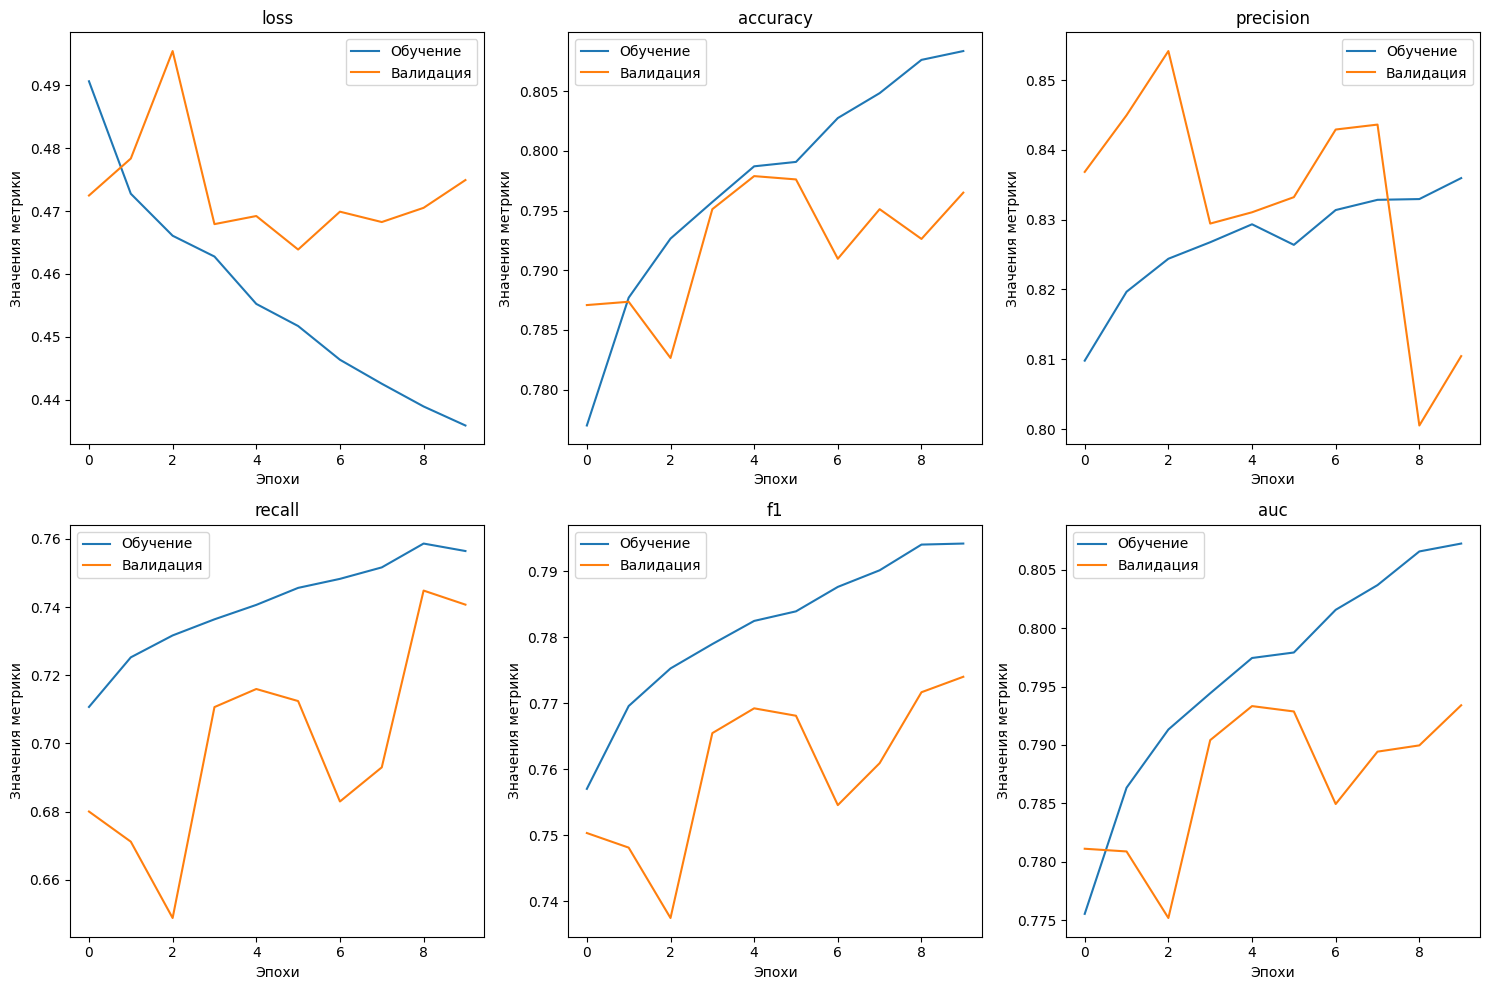

In [87]:
plot_metrics(history, 'Двунаправленная LSTM')

In [88]:
bid_simple_lstm_model.load_state_dict(torch.load('bid_lstm_model.pth', weights_only=True))

<All keys matched successfully>

## Оценка

In [89]:
loss_eval, history_eval, labels, preds = eval_model(bid_simple_lstm_model, test_loader, criterion, device)

Evaluating(test): 100%|██████████| 451/451 [00:05<00:00, 89.02it/s]


In [90]:
show_metrics(labels, preds, 'Двунаправленная LSTM')


                Двунаправленная LSTM
 auc: 0.794174675001797             
 report:                                
              precision    recall  f1-score   support

         0.0       0.76      0.87      0.81      7273
         1.0       0.85      0.71      0.78      7158

    accuracy                           0.79     14431
   macro avg       0.80      0.79      0.79     14431
weighted avg       0.80      0.79      0.79     14431


    


['accuracy', 'precision', 'recall', 'F1', 'AUC', 'loss']
[0.7948, 0.8486, 0.7136, 0.7753, 0.7942, 0.4555]


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


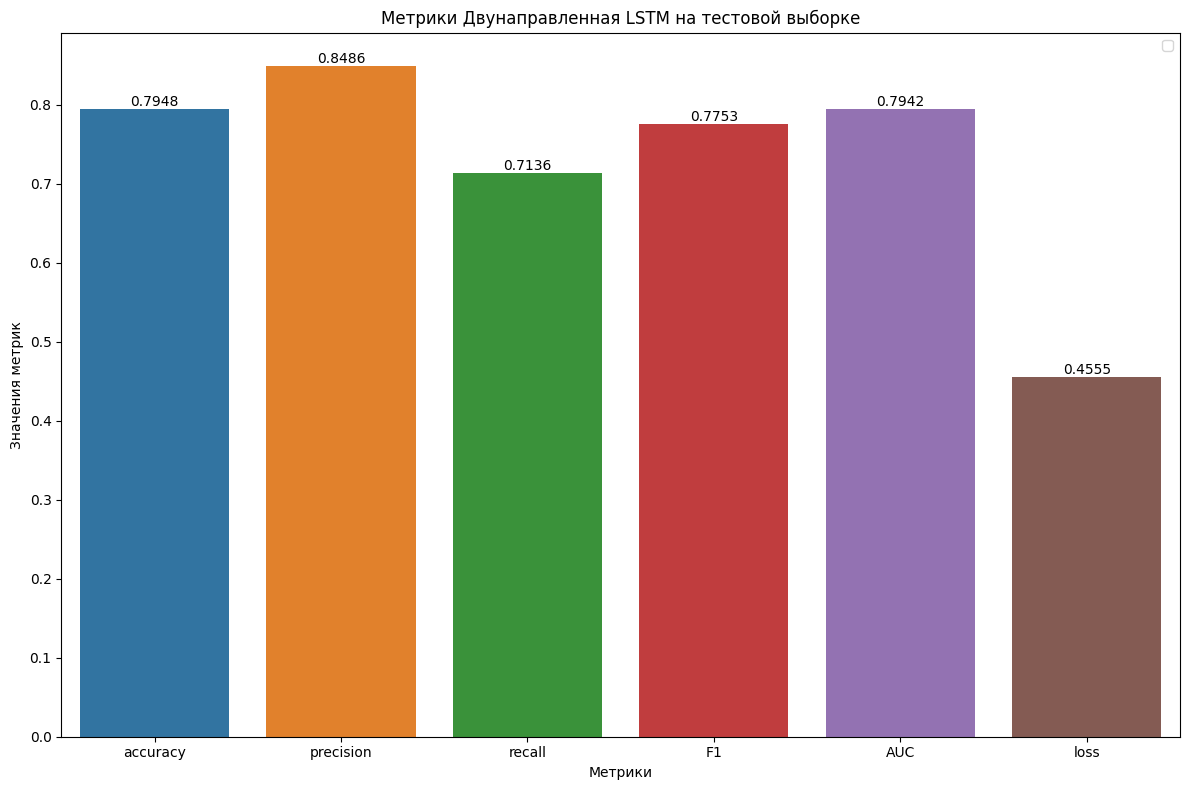

In [91]:
plot_metrics_eval(history_eval, "Двунаправленная LSTM")

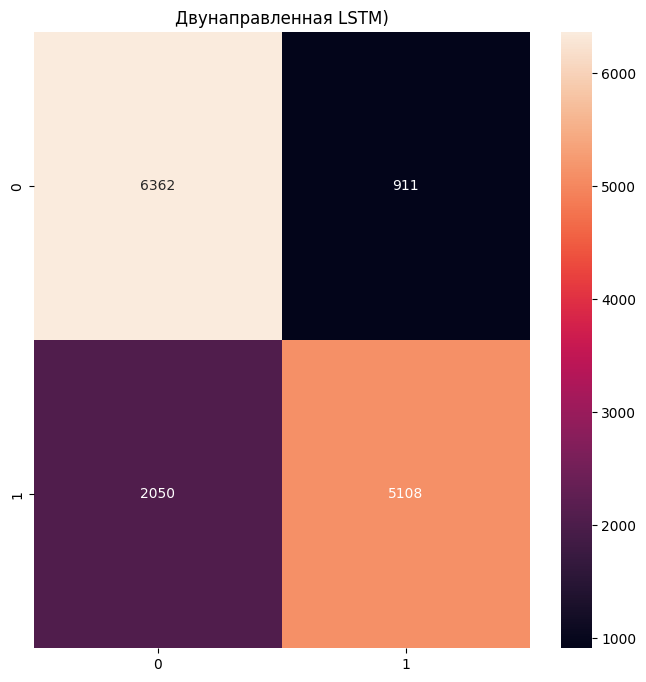

In [92]:
show_confusion_matrix(labels, preds, f'Двунаправленная LSTM)')

# LSTM + CNN

In [93]:
class lstm_cnn(nn.Module):
   def __init__(self, vocab_size, embedding_matrix, embedding_dim, hidden_dim, num_filters, kernel_size, output_dim, dropout_rate, num_layers):
       super(lstm_cnn, self).__init__()
       embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)
       self.embedding = nn.Embedding.from_pretrained(embedding_matrix)
       self.dropout = nn.Dropout(dropout_rate)
       self.lstm = nn.LSTM(input_size=embedding_dim, 
                           hidden_size=hidden_dim, 
                           batch_first=True,
                           bidirectional=True,
                           num_layers=num_layers, 
                           dropout=dropout_rate if num_layers > 1 else 0,
                           )
       # self.ln = nn.LayerNorm(hidden_dim * 2)
       self.conv1 = nn.Conv1d(in_channels = hidden_dim * 2, 
                              out_channels=num_filters, 
                              kernel_size=kernel_size,
                              padding='same')
       self.bn = nn.BatchNorm1d(num_filters)
       self.relu = torch.nn.ReLU()
       
       self.fc1 = nn.Linear(num_filters, output_dim) 
   def forward(self, x):
       embedded = self.dropout(self.embedding(x))
       lstm_out,_ = self.lstm(embedded)
       # lstm_out = self.ln(lstm_out)
       lstm_out = lstm_out.permute(0, 2, 1)
       conv_out = self.conv1(lstm_out)
       conv_out = self.bn(conv_out)
       conv_out = self.relu(conv_out)
       pool = F.max_pool1d(conv_out, conv_out.shape[2]).squeeze(2)
       pool = self.dropout(pool)
       # print("Размер перед fc:", pool.shape)
       out = self.fc1(pool)
       return out

## Обучение LSTM + CNN

In [94]:
# Гиперпараметры
embedding_dim = 300
hidden_dim = 256
num_layers = 1
kernel_size = 3
num_filters = 128
output_dim = 1
lr = 0.001
num_epochs = 100
dropout_rate = 0.25
weight_decay = 0.0001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [95]:
lstm_cnn_model = lstm_cnn(vocab_size=len(vocabulary), 
                          embedding_matrix=embedding_matrix,
                          embedding_dim=embedding_dim,
                          hidden_dim=hidden_dim,
                          num_layers=num_layers,
                          num_filters=num_filters,
                          kernel_size=kernel_size,
                          output_dim=output_dim,
                          dropout_rate=0.25
                         )

In [96]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(lstm_cnn_model.parameters(), lr=lr, weight_decay=weight_decay)
early_stopping = Early_stopping(patience=5, save_path="lstm_cnn.pth")
lstm_cnn_model.to(device)

lstm_cnn(
  (embedding): Embedding(40395, 300)
  (dropout): Dropout(p=0.25, inplace=False)
  (lstm): LSTM(300, 256, batch_first=True, bidirectional=True)
  (conv1): Conv1d(512, 128, kernel_size=(3,), stride=(1,), padding=same)
  (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (fc1): Linear(in_features=128, out_features=1, bias=True)
)

In [97]:
print(lstm_cnn_model)

lstm_cnn(
  (embedding): Embedding(40395, 300)
  (dropout): Dropout(p=0.25, inplace=False)
  (lstm): LSTM(300, 256, batch_first=True, bidirectional=True)
  (conv1): Conv1d(512, 128, kernel_size=(3,), stride=(1,), padding=same)
  (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (fc1): Linear(in_features=128, out_features=1, bias=True)
)


In [98]:
history, _ = train_model(model=lstm_cnn_model,
            train_loader=train_loader,
            valid_loader=valid_loader,
            criterion=criterion,
            optimizer=optimizer,
            device=device,
            num_epochs=num_epochs,
            early_stopping=early_stopping
           )

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 1/100
--------------------
-----Обучение-----


Epochs:   1%|          | 1/100 [00:58<1:35:45, 58.03s/it]

Train Loss: 0.5250 | Train Acc: 0.7591 |  Train Precision: 0.7856 | Train Recall: 0.6977 |  Train F1: 0.7390 | Train AUC: 0.7578
Val Loss: 0.4694 | Val Acc: 0.7865 |  Val Precision: 0.8313 | Val Recall: 0.6853 |  Val F1: 0.7513 | Val AUC: 0.7809
Best loss: 0.46942792534828187

Epoch 2/100
--------------------
-----Обучение-----


Epochs:   2%|▏         | 2/100 [01:55<1:34:34, 57.90s/it]

Train Loss: 0.4805 | Train Acc: 0.7815 |  Train Precision: 0.8162 | Train Recall: 0.7139 |  Train F1: 0.7616 | Train AUC: 0.7801
Val Loss: 0.4836 | Val Acc: 0.7735 |  Val Precision: 0.7517 | Val Recall: 0.7743 |  Val F1: 0.7628 | Val AUC: 0.7735

Epoch 3/100
--------------------
-----Обучение-----


Epochs:   3%|▎         | 3/100 [02:53<1:33:25, 57.79s/it]

Train Loss: 0.4701 | Train Acc: 0.7871 |  Train Precision: 0.8178 | Train Recall: 0.7263 |  Train F1: 0.7693 | Train AUC: 0.7858
Val Loss: 0.5054 | Val Acc: 0.7710 |  Val Precision: 0.7318 | Val Recall: 0.8103 |  Val F1: 0.7690 | Val AUC: 0.7732

Epoch 4/100
--------------------
-----Обучение-----


Epochs:   4%|▍         | 4/100 [03:50<1:32:03, 57.54s/it]

Train Loss: 0.4650 | Train Acc: 0.7889 |  Train Precision: 0.8192 | Train Recall: 0.7291 |  Train F1: 0.7715 | Train AUC: 0.7876
Val Loss: 0.4843 | Val Acc: 0.7807 |  Val Precision: 0.7539 | Val Recall: 0.7926 |  Val F1: 0.7728 | Val AUC: 0.7814

Epoch 5/100
--------------------
-----Обучение-----


Epochs:   5%|▌         | 5/100 [04:48<1:31:12, 57.60s/it]

Train Loss: 0.4590 | Train Acc: 0.7928 |  Train Precision: 0.8218 | Train Recall: 0.7356 |  Train F1: 0.7763 | Train AUC: 0.7915
Val Loss: 0.4720 | Val Acc: 0.7935 |  Val Precision: 0.8485 | Val Recall: 0.6830 |  Val F1: 0.7568 | Val AUC: 0.7873

Epoch 6/100
--------------------
-----Обучение-----
Train Loss: 0.4518 | Train Acc: 0.7965 |  Train Precision: 0.8249 | Train Recall: 0.7410 |  Train F1: 0.7807 | Train AUC: 0.7953
Val Loss: 0.4649 | Val Acc: 0.7965 |  Val Precision: 0.8403 | Val Recall: 0.7006 |  Val F1: 0.7641 | Val AUC: 0.7912
Best loss: 0.46490798592567445


Epochs:   6%|▌         | 6/100 [05:46<1:30:20, 57.66s/it]


Epoch 7/100
--------------------
-----Обучение-----
Train Loss: 0.4456 | Train Acc: 0.8001 |  Train Precision: 0.8259 | Train Recall: 0.7488 |  Train F1: 0.7855 | Train AUC: 0.7989
Val Loss: 0.4641 | Val Acc: 0.7935 |  Val Precision: 0.8127 | Val Recall: 0.7289 |  Val F1: 0.7686 | Val AUC: 0.7899
Best loss: 0.46411667466163636


Epochs:   7%|▋         | 7/100 [06:43<1:29:13, 57.57s/it]


Epoch 8/100
--------------------
-----Обучение-----


Epochs:   8%|▊         | 8/100 [07:40<1:28:03, 57.43s/it]

Train Loss: 0.4371 | Train Acc: 0.8054 |  Train Precision: 0.8295 | Train Recall: 0.7576 |  Train F1: 0.7919 | Train AUC: 0.8043
Val Loss: 0.4817 | Val Acc: 0.7865 |  Val Precision: 0.7738 | Val Recall: 0.7720 |  Val F1: 0.7729 | Val AUC: 0.7857

Epoch 9/100
--------------------
-----Обучение-----


Epochs:   9%|▉         | 9/100 [08:38<1:27:13, 57.51s/it]

Train Loss: 0.4247 | Train Acc: 0.8114 |  Train Precision: 0.8361 | Train Recall: 0.7639 |  Train F1: 0.7984 | Train AUC: 0.8104
Val Loss: 0.4768 | Val Acc: 0.7901 |  Val Precision: 0.7749 | Val Recall: 0.7808 |  Val F1: 0.7778 | Val AUC: 0.7896

Epoch 10/100
--------------------
-----Обучение-----


Epochs:  10%|█         | 10/100 [09:35<1:26:10, 57.45s/it]

Train Loss: 0.4097 | Train Acc: 0.8188 |  Train Precision: 0.8413 | Train Recall: 0.7756 |  Train F1: 0.8071 | Train AUC: 0.8178
Val Loss: 0.4877 | Val Acc: 0.7804 |  Val Precision: 0.7666 | Val Recall: 0.7666 |  Val F1: 0.7666 | Val AUC: 0.7797

Epoch 11/100
--------------------
-----Обучение-----


Epochs:  11%|█         | 11/100 [10:32<1:25:07, 57.39s/it]

Train Loss: 0.3940 | Train Acc: 0.8276 |  Train Precision: 0.8488 | Train Recall: 0.7877 |  Train F1: 0.8171 | Train AUC: 0.8268
Val Loss: 0.4893 | Val Acc: 0.7862 |  Val Precision: 0.7953 | Val Recall: 0.7348 |  Val F1: 0.7639 | Val AUC: 0.7834

Epoch 12/100
--------------------
-----Обучение-----


Epochs:  11%|█         | 11/100 [11:30<1:33:05, 62.76s/it]

Train Loss: 0.3672 | Train Acc: 0.8415 |  Train Precision: 0.8611 | Train Recall: 0.8058 |  Train F1: 0.8325 | Train AUC: 0.8407
Val Loss: 0.5286 | Val Acc: 0.7807 |  Val Precision: 0.7853 | Val Recall: 0.7348 |  Val F1: 0.7592 | Val AUC: 0.7781
Early stopping triggered! Best model weights saved.
Stop after 11 epochs


<ipython-input-30-3aeef0aace76>:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 3, i + 1)  # 2 строки, 3 столбца, i+1 — позиция графика


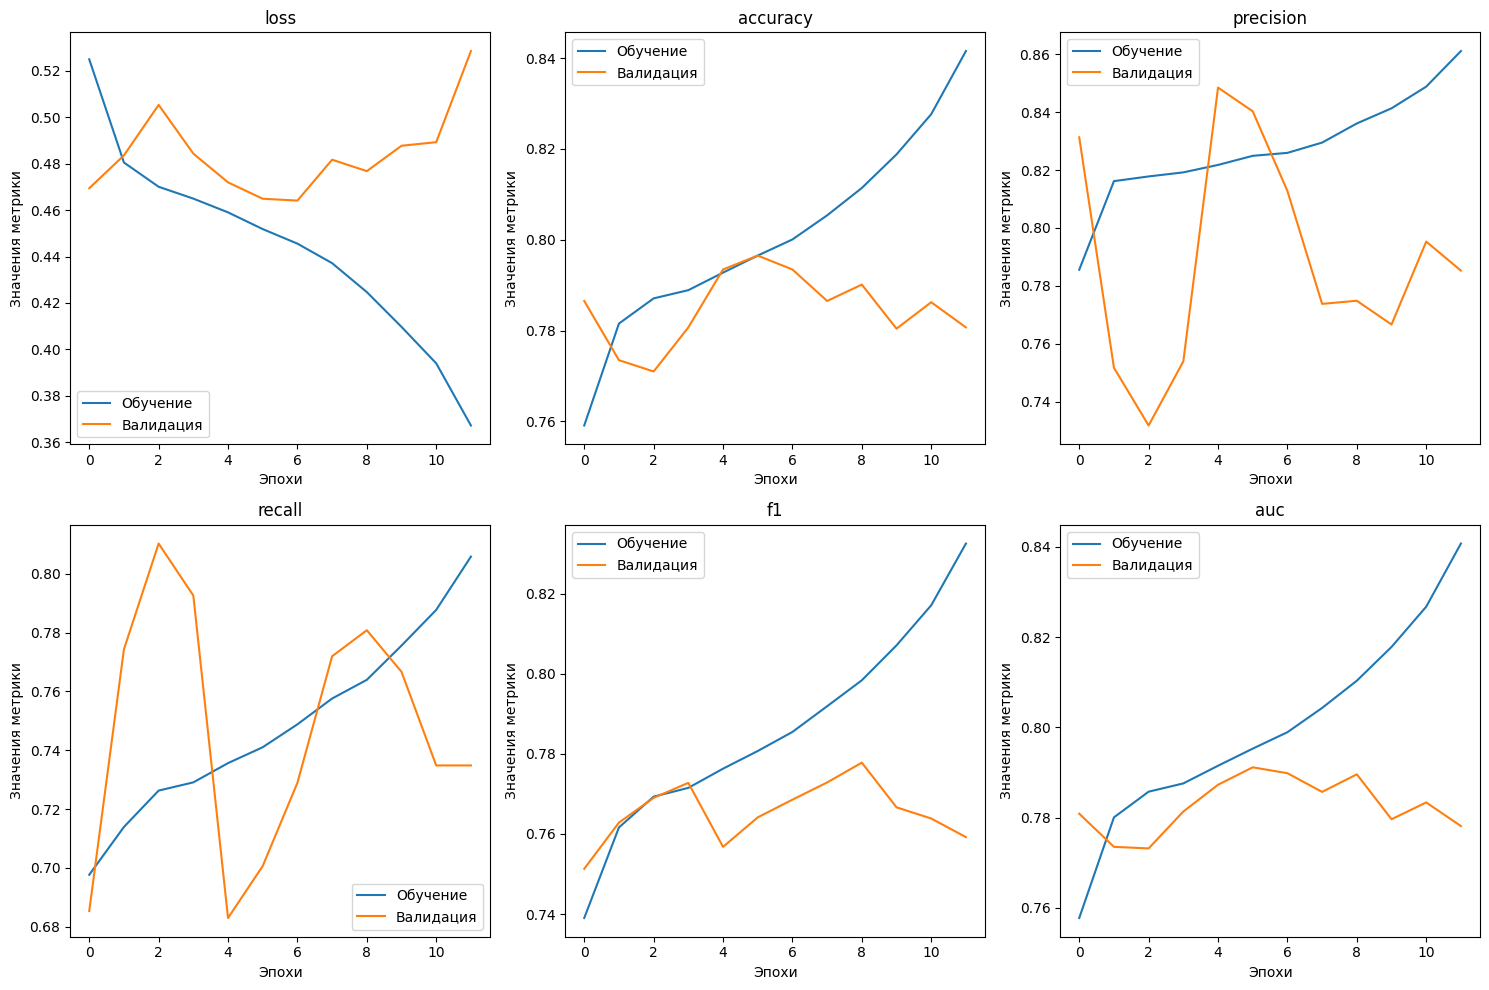

In [99]:
plot_metrics(history, "LSTM + CNN")

In [100]:
lstm_cnn_model.load_state_dict(torch.load('/kaggle/working/lstm_cnn.pth', weights_only=True))

<All keys matched successfully>

## Оценка LSTM + CNN

In [101]:
loss_eval, history_eval, labels, preds = eval_model(lstm_cnn_model, test_loader, criterion, device)

Evaluating(test): 100%|██████████| 451/451 [00:05<00:00, 81.83it/s]


In [102]:
show_metrics(labels, preds, 'Комбинация двунаправленной LSTM и CNN')


                Комбинация двунаправленной LSTM и CNN
 auc: 0.7905559271130573             
 report:                                
              precision    recall  f1-score   support

         0.0       0.76      0.85      0.80      7273
         1.0       0.83      0.73      0.78      7158

    accuracy                           0.79     14431
   macro avg       0.79      0.79      0.79     14431
weighted avg       0.79      0.79      0.79     14431


    


['accuracy', 'precision', 'recall', 'F1', 'AUC', 'loss']
[0.791, 0.8252, 0.7341, 0.777, 0.7906, 0.4602]


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


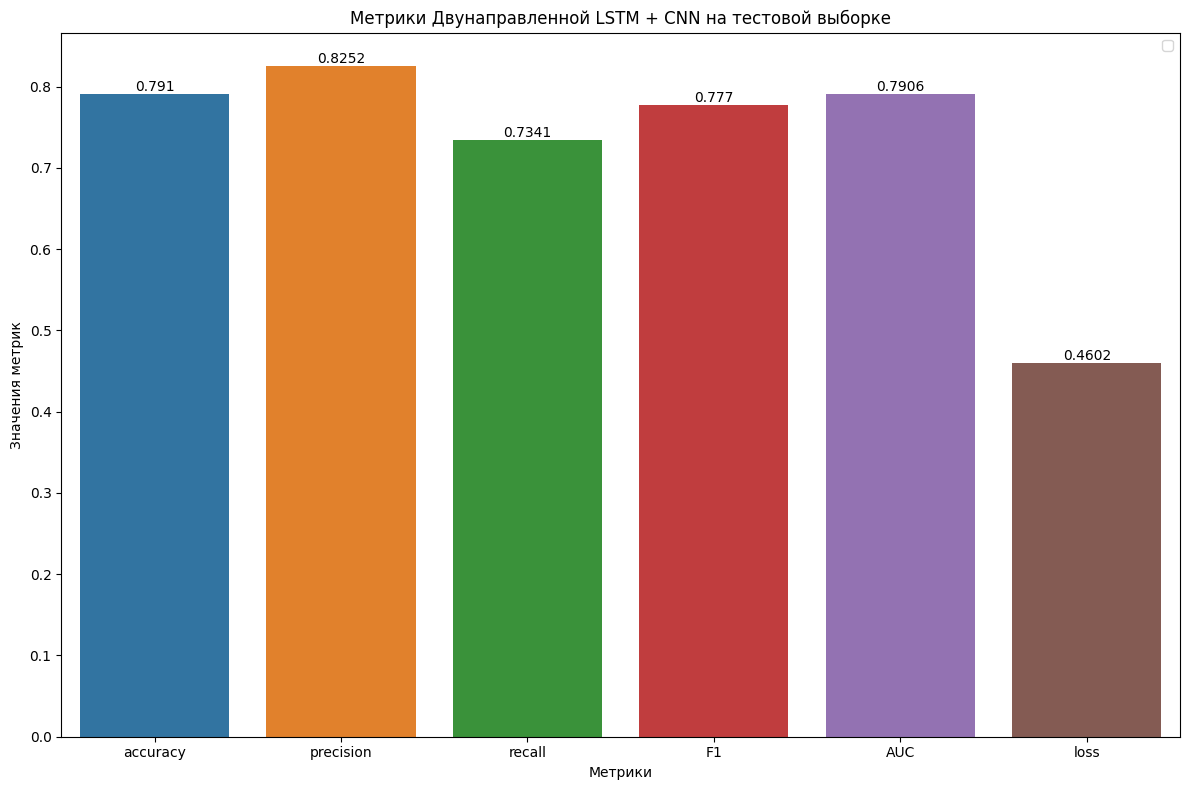

In [103]:
plot_metrics_eval(history_eval, "Двунаправленной LSTM + CNN")

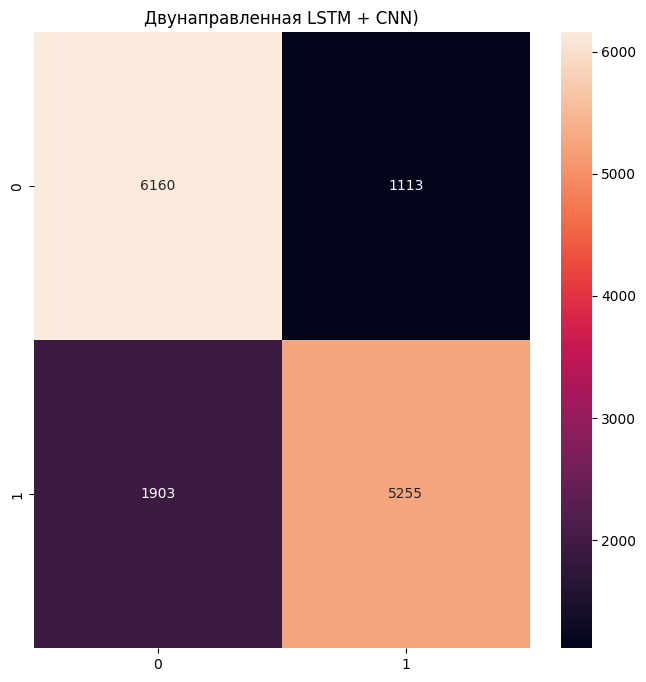

In [104]:
show_confusion_matrix(labels, preds, f'Двунаправленная LSTM + CNN)')

# LSTM + paralel CNN

In [105]:
class lstm_parallel_cnn(nn.Module):
   def __init__(self, vocab_size, embedding_matrix, embedding_dim, hidden_dim, num_filters, kernels_sizes, output_dim, dropout_rate, num_layers):
       super(lstm_parallel_cnn, self).__init__()
       embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)
       self.embedding = nn.Embedding.from_pretrained(embedding_matrix)
       self.dropout = nn.Dropout(dropout_rate)
       self.lstm = nn.LSTM(input_size=embedding_dim, 
                           hidden_size=hidden_dim, 
                           batch_first=True,
                           bidirectional=True,
                           num_layers=num_layers, 
                           dropout=dropout_rate if num_layers > 1 else 0,
                           )
       # self.ln = nn.LayerNorm(hidden_dim * 2)
       
       # Список сверточных слоев
       self.conv_lst = nn.ModuleList([
           nn.Sequential(
               nn.Conv1d(in_channels=hidden_dim*2,out_channels=num_filters,kernel_size=ks),
               nn.BatchNorm1d(num_filters),
               nn.ReLU(),
               nn.Dropout(dropout_rate),
               nn.AdaptiveMaxPool1d(1),
               nn.Flatten()
                        ) for ks in kernels_sizes])
       
       self.bn = nn.BatchNorm1d(num_filters)
       self.relu = torch.nn.ReLU()
       
       self.fc1 = nn.Linear(num_filters*len(kernels_sizes), output_dim) 
   def forward(self, x):
       embedded = self.dropout(self.embedding(x))
       lstm_out,_ = self.lstm(embedded)
       # lstm_out = self.ln(lstm_out)
       lstm_out = lstm_out.permute(0, 2, 1)
       conv_outs = [conv(lstm_out) for conv in self.conv_lst]
       conv_out_cat = torch.cat(conv_outs, dim=1)
       out = self.fc1(conv_out_cat)
       return out

## Обучение LSTM + parallel CNN

In [106]:
lstm_parallel_cnn.__init__

<function __main__.lstm_parallel_cnn.__init__(self, vocab_size, embedding_matrix, embedding_dim, hidden_dim, num_filters, kernels_sizes, output_dim, dropout_rate, num_layers)>

In [107]:
# Гиперпараметры
embedding_dim = 300
hidden_dim = 256
num_layers = 1
kernels_sizes = [2,3,4]
num_filters = 256
output_dim = 1
lr = 0.001
num_epochs = 100
dropout_rate = 0.25
weight_decay = 0.0001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [108]:
lstm_parallel_cnn_model = lstm_parallel_cnn(vocab_size=len(vocabulary), 
                                            embedding_matrix=embedding_matrix,
                                            embedding_dim=embedding_dim,
                                            hidden_dim=hidden_dim,
                                            num_filters=num_filters,
                                            kernels_sizes=kernels_sizes,
                                            output_dim=output_dim,
                                            dropout_rate=dropout_rate,
                                            num_layers=num_layers)
                                            

In [109]:
print(lstm_parallel_cnn_model)

lstm_parallel_cnn(
  (embedding): Embedding(40395, 300)
  (dropout): Dropout(p=0.25, inplace=False)
  (lstm): LSTM(300, 256, batch_first=True, bidirectional=True)
  (conv_lst): ModuleList(
    (0): Sequential(
      (0): Conv1d(512, 256, kernel_size=(2,), stride=(1,))
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.25, inplace=False)
      (4): AdaptiveMaxPool1d(output_size=1)
      (5): Flatten(start_dim=1, end_dim=-1)
    )
    (1): Sequential(
      (0): Conv1d(512, 256, kernel_size=(3,), stride=(1,))
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.25, inplace=False)
      (4): AdaptiveMaxPool1d(output_size=1)
      (5): Flatten(start_dim=1, end_dim=-1)
    )
    (2): Sequential(
      (0): Conv1d(512, 256, kernel_size=(4,), stride=(1,))
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running

In [110]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(lstm_parallel_cnn_model.parameters(), lr=lr, weight_decay=weight_decay)
early_stopping = Early_stopping(patience=5, save_path="lstm_parallel_cnn.pth")
lstm_parallel_cnn_model.to(device)

lstm_parallel_cnn(
  (embedding): Embedding(40395, 300)
  (dropout): Dropout(p=0.25, inplace=False)
  (lstm): LSTM(300, 256, batch_first=True, bidirectional=True)
  (conv_lst): ModuleList(
    (0): Sequential(
      (0): Conv1d(512, 256, kernel_size=(2,), stride=(1,))
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.25, inplace=False)
      (4): AdaptiveMaxPool1d(output_size=1)
      (5): Flatten(start_dim=1, end_dim=-1)
    )
    (1): Sequential(
      (0): Conv1d(512, 256, kernel_size=(3,), stride=(1,))
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.25, inplace=False)
      (4): AdaptiveMaxPool1d(output_size=1)
      (5): Flatten(start_dim=1, end_dim=-1)
    )
    (2): Sequential(
      (0): Conv1d(512, 256, kernel_size=(4,), stride=(1,))
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running

In [111]:
history, _ = train_model(model=lstm_parallel_cnn_model,
            train_loader=train_loader,
            valid_loader=valid_loader,
            criterion=criterion,
            optimizer=optimizer,
            device=device,
            num_epochs=num_epochs,
            early_stopping=early_stopping
           )

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 1/100
--------------------
-----Обучение-----


Epochs:   1%|          | 1/100 [01:33<2:34:58, 93.93s/it]

Train Loss: 0.5899 | Train Acc: 0.7580 |  Train Precision: 0.7864 | Train Recall: 0.6934 |  Train F1: 0.7369 | Train AUC: 0.7566
Val Loss: 0.5096 | Val Acc: 0.7535 |  Val Precision: 0.7000 | Val Recall: 0.8332 |  Val F1: 0.7608 | Val AUC: 0.7580
Best loss: 0.5095923086007436

Epoch 2/100
--------------------
-----Обучение-----
Train Loss: 0.4810 | Train Acc: 0.7805 |  Train Precision: 0.8139 | Train Recall: 0.7144 |  Train F1: 0.7609 | Train AUC: 0.7791
Val Loss: 0.4764 | Val Acc: 0.7923 |  Val Precision: 0.8114 | Val Recall: 0.7278 |  Val F1: 0.7673 | Val AUC: 0.7887
Best loss: 0.47643835345904034


Epochs:   2%|▏         | 2/100 [03:08<2:33:38, 94.07s/it]


Epoch 3/100
--------------------
-----Обучение-----
Train Loss: 0.4722 | Train Acc: 0.7844 |  Train Precision: 0.8152 | Train Recall: 0.7229 |  Train F1: 0.7663 | Train AUC: 0.7831
Val Loss: 0.4753 | Val Acc: 0.7857 |  Val Precision: 0.7877 | Val Recall: 0.7454 |  Val F1: 0.7660 | Val AUC: 0.7834
Best loss: 0.4752693176269531


Epochs:   3%|▎         | 3/100 [04:42<2:32:10, 94.13s/it]


Epoch 4/100
--------------------
-----Обучение-----
Train Loss: 0.4641 | Train Acc: 0.7914 |  Train Precision: 0.8203 | Train Recall: 0.7340 |  Train F1: 0.7747 | Train AUC: 0.7901
Val Loss: 0.4714 | Val Acc: 0.7918 |  Val Precision: 0.8075 | Val Recall: 0.7319 |  Val F1: 0.7679 | Val AUC: 0.7885
Best loss: 0.47139912446339927


Epochs:   4%|▍         | 4/100 [06:17<2:31:04, 94.42s/it]


Epoch 5/100
--------------------
-----Обучение-----
Train Loss: 0.4576 | Train Acc: 0.7929 |  Train Precision: 0.8165 | Train Recall: 0.7433 |  Train F1: 0.7782 | Train AUC: 0.7918
Val Loss: 0.4679 | Val Acc: 0.7926 |  Val Precision: 0.7931 | Val Recall: 0.7566 |  Val F1: 0.7744 | Val AUC: 0.7906
Best loss: 0.4679354170958201


Epochs:   5%|▌         | 5/100 [07:51<2:29:43, 94.56s/it]


Epoch 6/100
--------------------
-----Обучение-----


Epochs:   6%|▌         | 6/100 [09:25<2:27:39, 94.25s/it]

Train Loss: 0.4506 | Train Acc: 0.7957 |  Train Precision: 0.8202 | Train Recall: 0.7454 |  Train F1: 0.7810 | Train AUC: 0.7946
Val Loss: 0.4914 | Val Acc: 0.7777 |  Val Precision: 0.7418 | Val Recall: 0.8091 |  Val F1: 0.7740 | Val AUC: 0.7794

Epoch 7/100
--------------------
-----Обучение-----


Epochs:   7%|▋         | 7/100 [10:59<2:25:52, 94.11s/it]

Train Loss: 0.4409 | Train Acc: 0.8014 |  Train Precision: 0.8218 | Train Recall: 0.7582 |  Train F1: 0.7887 | Train AUC: 0.8005
Val Loss: 0.4705 | Val Acc: 0.7943 |  Val Precision: 0.7899 | Val Recall: 0.7666 |  Val F1: 0.7781 | Val AUC: 0.7927

Epoch 8/100
--------------------
-----Обучение-----


Epochs:   8%|▊         | 8/100 [12:33<2:24:17, 94.10s/it]

Train Loss: 0.4322 | Train Acc: 0.8061 |  Train Precision: 0.8244 | Train Recall: 0.7667 |  Train F1: 0.7945 | Train AUC: 0.8052
Val Loss: 0.4713 | Val Acc: 0.7982 |  Val Precision: 0.8181 | Val Recall: 0.7342 |  Val F1: 0.7739 | Val AUC: 0.7946

Epoch 9/100
--------------------
-----Обучение-----


Epochs:   9%|▉         | 9/100 [14:07<2:22:38, 94.05s/it]

Train Loss: 0.4167 | Train Acc: 0.8145 |  Train Precision: 0.8337 | Train Recall: 0.7753 |  Train F1: 0.8034 | Train AUC: 0.8137
Val Loss: 0.4828 | Val Acc: 0.7937 |  Val Precision: 0.8401 | Val Recall: 0.6936 |  Val F1: 0.7598 | Val AUC: 0.7881

Epoch 10/100
--------------------
-----Обучение-----


Epochs:   9%|▉         | 9/100 [15:40<2:38:33, 104.55s/it]

Train Loss: 0.3903 | Train Acc: 0.8270 |  Train Precision: 0.8420 | Train Recall: 0.7953 |  Train F1: 0.8180 | Train AUC: 0.8263
Val Loss: 0.4956 | Val Acc: 0.7741 |  Val Precision: 0.7529 | Val Recall: 0.7737 |  Val F1: 0.7632 | Val AUC: 0.7740
Early stopping triggered! Best model weights saved.
Stop after 9 epochs


<ipython-input-30-3aeef0aace76>:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 3, i + 1)  # 2 строки, 3 столбца, i+1 — позиция графика


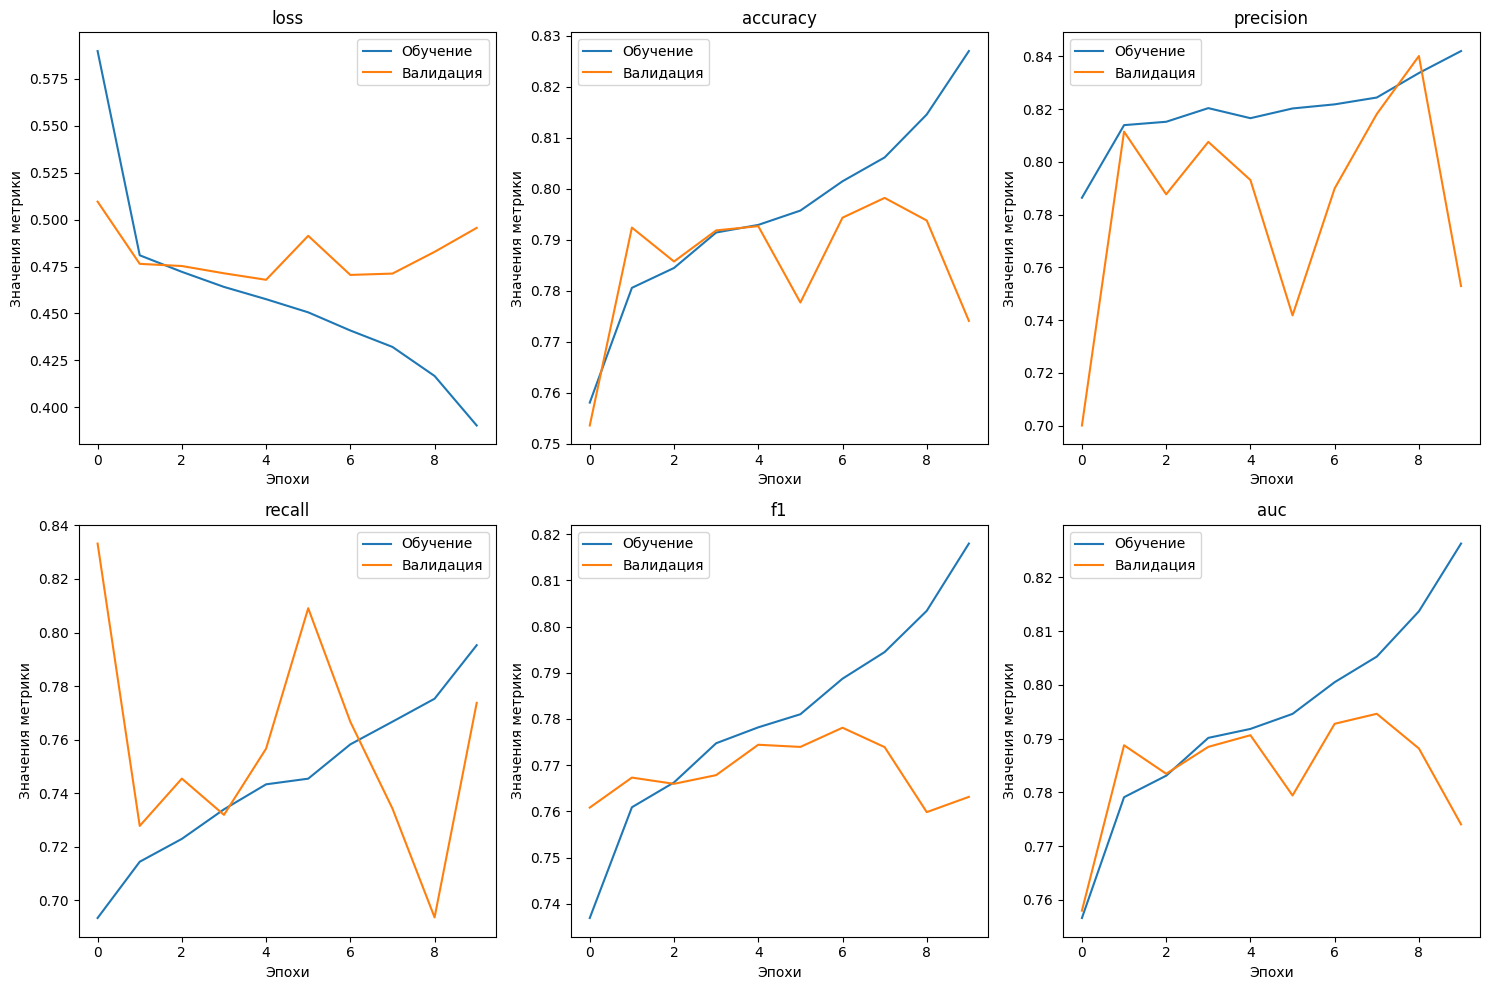

In [112]:
plot_metrics(history, "LSTM + параллельная CNN")

In [113]:
lstm_parallel_cnn_model.load_state_dict(torch.load('lstm_parallel_cnn.pth', weights_only=True))

<All keys matched successfully>

## Оценка LSTM + parallel CNN

In [114]:
loss_eval, history_eval, labels, preds = eval_model(lstm_parallel_cnn_model, test_loader, criterion, device)

Evaluating(test): 100%|██████████| 451/451 [00:08<00:00, 54.06it/s]


In [115]:
show_metrics(labels, preds, 'Двунаправленная LSTM + параллельный CNN')



                Двунаправленная LSTM + параллельный CNN
 auc: 0.7910642335265599             
 report:                                
              precision    recall  f1-score   support

         0.0       0.77      0.83      0.80      7273
         1.0       0.81      0.75      0.78      7158

    accuracy                           0.79     14431
   macro avg       0.79      0.79      0.79     14431
weighted avg       0.79      0.79      0.79     14431


    
